# Air Quality (PM2.5)

Johannes Thellmann (1969637)

# Content

1. [Motivation]  
2. [Dataset]  
    2.1 [Missing Values]  
    2.2 [Encoding Categorical Variables]  
    2.3 [Correlation]  
    2.4 [Split into Train/Valid/Test and Normalize]  
    2.5 [Performance Measures: $MSE$ and $R^2$]  
3. [Benchmark Model]  
4. [Machine Learning Model]  
    4.1 [Random Forests]  
        4.1.1 [Hyperparameters Random Forests]  
        4.1.2 [Hyperparameter Tuning Random Forests]  
        4.1.3 [Feature Importance]  
    4.2 [Gradient Boosting]  
        4.2.1 [Extreme Gradient Boosting]  
        4.2.2 [Hyperparameter Tuning Extreme Gradient Boosting]  
        4.1.3 [Feature Importance]  
5. [Conclusion]  
[Bibliography]  
[Declaration]


# 1. Motivation

An increasing number of different studies recognize adverse health effects of fine particular matter PM2.5 (particles with a diameter <2.5 $\mu m$). China’s rapid industrialization in the last two decades, sharply increases energy consumption and transportation (Pope et al., 2009, p. 376). Large cities suffer particularly from the resulting increase in particulate matter concentration. Green alternatives are the best option on the long run, but action is required as fast as possible. In addition to industry, traffic and energy supply, the concentration within cities is strongly dependant on external factors such as air temperature, air pressure, humidity, etc. That is one of the reasons, why particular matter concentration varies greatly throughout the year (Liang et al. 2016, p. 10221). Permanent driving bans are a challenge and alternative solutions are needed. To compromise between drastic measures, like driving bans, day-dependent restrictions come to mind depending on the weather conditions.
In order to keep supply chains running, the date of driving bans has to be announced in advance. 
Weather forecast provide meterological data (temperature, air pressure, humidity, etc.) that can be used to predict particular matter concentration.
The goal of this report is to develop a model to predict PM2.5 concentration values given weather forecasts to build the basis for day-dependent interventions to improve air purity in big cities.

# 2. Dataset

The dataset comes from Liang et al. (2016) and is collected to compare PM2.5 measures of US posts to chinese posts in five big cities. The dataset can be downloaded from https://archive.ics.uci.edu/ml/datasets/PM2.5+Data+of+Five+Chinese+Cities (last acess: August 30th 2021). 
The cities are Beijing, Chengdu, Guangzhou, Shanghai and Shenyang. In the past several cases of wrong reports on PM2.5 concentration by chinese authorities were reported. Liang et al. (2016) conclude a high conformity of US measurements and chinese measurements. The dataset contains hourly measurements of the PM2.5 ($\mu g/m^{3}$) concentration from January 2010 until December 2015 (52584 measures) for the US posts and 2-3 geographically close chinese posts per city. Next to the date and seasonal information the following meterological data is included: Dew Point ($^{\circ}C$), TEMP: Temperature ($^{\circ}C$), HUMI: Humidity (%), PRES: Pressure ($hPa$), cbwd: Combined wind direction, Iws: Cumulated wind speed ($m/s$), precipitation: hourly precipitation ($mm$), Iprec: Cumulated precipitation ($mm$). As mentioned in the introduction the seasonal and meterological information (predictors) is used to predict the PM2.5 concentration (target variable). The following chapter is a closer look at the dataset and a description of the necessary data preparation steps performed.

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#beijing_path = '/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/All Datasets/FiveCitiePMData/Beijing.csv'
#chengdu_path = '/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/All Datasets/FiveCitiePMData/Chengdu.csv'
#guangzhou_path = '/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/All Datasets/FiveCitiePMData/Guangzhou.csv'
#shanghai_path = '/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/All Datasets/FiveCitiePMData/Shanghai.csv'
#shenyang_path = '/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/All Datasets/FiveCitiePMData/shenyang.csv'

beijing_path = '/Dataset/All Datasets/FiveCitiePMData/Beijing.csv'
chengdu_path = '/Dataset/All Datasets/FiveCitiePMData/Chengdu.csv'
guangzhou_path = '/Dataset/All Datasets/FiveCitiePMData/Guangzhou.csv'
shanghai_path = '/Dataset/All Datasets/FiveCitiePMData/Shanghai.csv'
shenyang_path = '/All Datasets/FiveCitiePMData/shenyang.csv'


beijing = pd.read_csv(beijing_path,index_col = 0)
chengdu = pd.read_csv(chengdu_path,index_col = 0)
guangzhou = pd.read_csv(guangzhou_path,index_col = 0)
shanghai = pd.read_csv(shanghai_path,index_col = 0)
shenyang = pd.read_csv(shenyang_path, index_col = 0)

: 

In [3]:
for city in [[beijing,'Beijing'], [chengdu,'Chengdu'], [guangzhou,'Guangzhou'],
             [shanghai, 'Shanghai'], [shenyang, 'Shenyang']]:
    print(city[1] + ' shape: ' + str(city[0].shape))

Beijing shape: (52584, 17)
Chengdu shape: (52584, 16)
Guangzhou shape: (52584, 16)
Shanghai shape: (52584, 16)
Shenyang shape: (52584, 16)


Text(0, 0.5, 'Quantity')

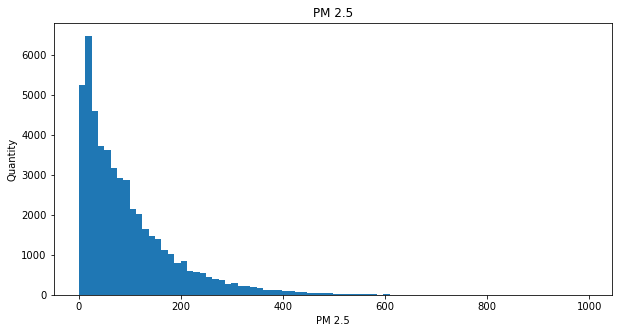

In [5]:
#Visualization
fig = plt.figure(figsize = (10,5))
plt.hist(beijing['PM_US Post'], bins=80)
#plt.title('PM 2.5')
plt.title('PM 2.5'.format(beijing['PM_US Post'].skew()))
plt.xlabel('PM 2.5')
plt.ylabel('Quantity')

In [6]:
beijing.head()

,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
No,,,,,,,,,,,,,,,,,
1,2010,1,1,0,4,NaN,NaN,NaN,NaN,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0
2,2010,1,1,1,4,NaN,NaN,NaN,NaN,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0
3,2010,1,1,2,4,NaN,NaN,NaN,NaN,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0
4,2010,1,1,3,4,NaN,NaN,NaN,NaN,-21.0,55.0,1019.0,-14.0,NW,9.84,0.0,0.0
5,2010,1,1,4,4,NaN,NaN,NaN,NaN,-20.0,51.0,1018.0,-12.0,NW,12.97,0.0,0.0


The import of the datasets worked as expected, but it seems that a lot of data is missing.

In [7]:
df_isna = pd.DataFrame({'beijing':beijing.isna().sum(),
                        'chengdu':chengdu.isna().sum(), 
                        'guangzhou':guangzhou.isna().sum(),
                        'shanghai':shanghai.isna().sum(),
                        'shenyang':shenyang.isna().sum()}, index = ['year', 'month', 'day', 'hour', 'season','PM_US Post', 'DEWP', 'HUMI', 
                        'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'Iprec',
                        'PM_Dongsi', 'PM_Dongsihuan','PM_Nongzhanguan','PM_Caotangsi',
                        'PM_Shahepu','PM_City Station',
                        'PM_5th Middle School', 'PM_Jingan',
                        'PM_Xuhui','PM_Taiyuanjie','PM_Xiaoheyan'])

In [8]:
df_isna

,beijing,chengdu,guangzhou,shanghai,shenyang
year,0.0,0.0,0.0,0.0,0.0
month,0.0,0.0,0.0,0.0,0.0
day,0.0,0.0,0.0,0.0,0.0
hour,0.0,0.0,0.0,0.0,0.0
season,0.0,0.0,1.0,0.0,0.0
PM_US Post,2197.0,23684.0,20232.0,18545.0,30904.0
DEWP,5.0,529.0,1.0,13.0,692.0
HUMI,339.0,535.0,1.0,13.0,680.0
PRES,339.0,521.0,1.0,28.0,692.0
TEMP,5.0,527.0,1.0,13.0,692.0


The dataset contains a lot of missing information. Especially for Chengdu, Guangzhou, Shanghai and Shenyang the measurements for PM2.5 values seem sparse. The PM2.5 Measures of the US Posts are in general more complete compared to the chinese posts. Since Liang et al. (2016) argue against big differences between the US and chinese measures missing US PM2.5 concentration values are replaced with chinese values if available. The values of the geographically closest chinese measuring station are used first.

In [9]:
#replace missing values with chinese measures
beijing['PM_US Post'].fillna(beijing['PM_Nongzhanguan'], inplace=True)
beijing['PM_US Post'].fillna(beijing['PM_Dongsihuan'], inplace=True)
beijing['PM_US Post'].fillna(beijing['PM_Dongsi'], inplace=True)
chengdu['PM_US Post'].fillna(chengdu['PM_Shahepu'], inplace=True)
chengdu['PM_US Post'].fillna(chengdu['PM_Caotangsi'], inplace=True)
guangzhou['PM_US Post'].fillna(guangzhou['PM_City Station'], inplace=True)
guangzhou['PM_US Post'].fillna(guangzhou['PM_5th Middle School'], inplace=True)
shanghai['PM_US Post'].fillna(shanghai['PM_Jingan'], inplace=True)
shanghai['PM_US Post'].fillna(shanghai['PM_Xuhui'], inplace=True)
shenyang['PM_US Post'].fillna(shenyang['PM_Taiyuanjie'], inplace=True)
shenyang['PM_US Post'].fillna(shenyang['PM_Xiaoheyan'], inplace=True)

#and drop columns with chinese measures
beijing = beijing.drop(['PM_Dongsi', 'PM_Dongsihuan','PM_Nongzhanguan'], axis = 1)
chengdu = chengdu.drop(['PM_Caotangsi', 'PM_Shahepu'], axis = 1)
guangzhou = guangzhou.drop(['PM_City Station','PM_5th Middle School'], axis = 1)
shanghai = shanghai.drop(['PM_Jingan','PM_Xuhui'], axis = 1)
shenyang = shenyang.drop([ 'PM_Taiyuanjie', 'PM_Xiaoheyan'], axis = 1)

beijing.isna().sum()
chengdu.isna().sum()
guangzhou.isna().sum()
shanghai.isna().sum()
shenyang.isna().sum()

df_isna = pd.DataFrame({'beijing':beijing.isna().sum(),
                        'chengdu':chengdu.isna().sum(), 
                        'guangzhou':guangzhou.isna().sum(),
                        'shanghai':shanghai.isna().sum(),
                        'shenyang':shenyang.isna().sum()}, index = ['year', 'month', 'day', 'hour', 'season','PM_US Post', 'DEWP', 'HUMI', 
                        'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'Iprec'])

df_isna

,beijing,chengdu,guangzhou,shanghai,shenyang
year,0,0,0,0,0
month,0,0,0,0,0
day,0,0,0,0,0
hour,0,0,0,0,0
season,0,0,1,0,0
PM_US Post,1894,22082,19211,17789,26699
DEWP,5,529,1,13,692
HUMI,339,535,1,13,680
PRES,339,521,1,28,692
TEMP,5,527,1,13,692


Still many missing values remain and some further exploration is necessary.

In [10]:
#Create Columns with Date in datetime-format
beijing['date'] = pd.to_datetime(beijing['year'].astype(str) +'-'+ beijing['month'].astype(str) +'-'+ beijing['day'].astype(str) +'-'+ beijing['hour'].astype(str), format = '%Y-%m-%d-%H')
chengdu['date'] = pd.to_datetime(chengdu['year'].astype(str) +'-'+ chengdu['month'].astype(str) +'-'+ chengdu['day'].astype(str) +'-'+ chengdu['hour'].astype(str), format = '%Y-%m-%d-%H')
guangzhou['date'] = pd.to_datetime(beijing['year'].astype(str) +'-'+ guangzhou['month'].astype(str) +'-'+ guangzhou['day'].astype(str) +'-'+ guangzhou['hour'].astype(str), format = '%Y-%m-%d-%H')
shanghai['date'] = pd.to_datetime(shanghai['year'].astype(str) +'-'+ shanghai['month'].astype(str) +'-'+ shanghai['day'].astype(str) +'-'+ shanghai['hour'].astype(str), format = '%Y-%m-%d-%H')
shenyang['date'] = pd.to_datetime(shenyang['year'].astype(str) +'-'+ shenyang['month'].astype(str) +'-'+ shenyang['day'].astype(str) +'-'+ shenyang['hour'].astype(str), format = '%Y-%m-%d-%H')

#Make measuring date the index
beijing['index'] = beijing['date']
chengdu['index'] = chengdu['date']
guangzhou['index'] = guangzhou['date']
shanghai['index'] = guangzhou['date']
shenyang['index'] = guangzhou['date']
beijing = beijing.set_index('index')
chengdu = chengdu.set_index('index')
guangzhou = guangzhou.set_index('index')
shanghai = shanghai.set_index('index')
shenyang = shenyang.set_index('index')

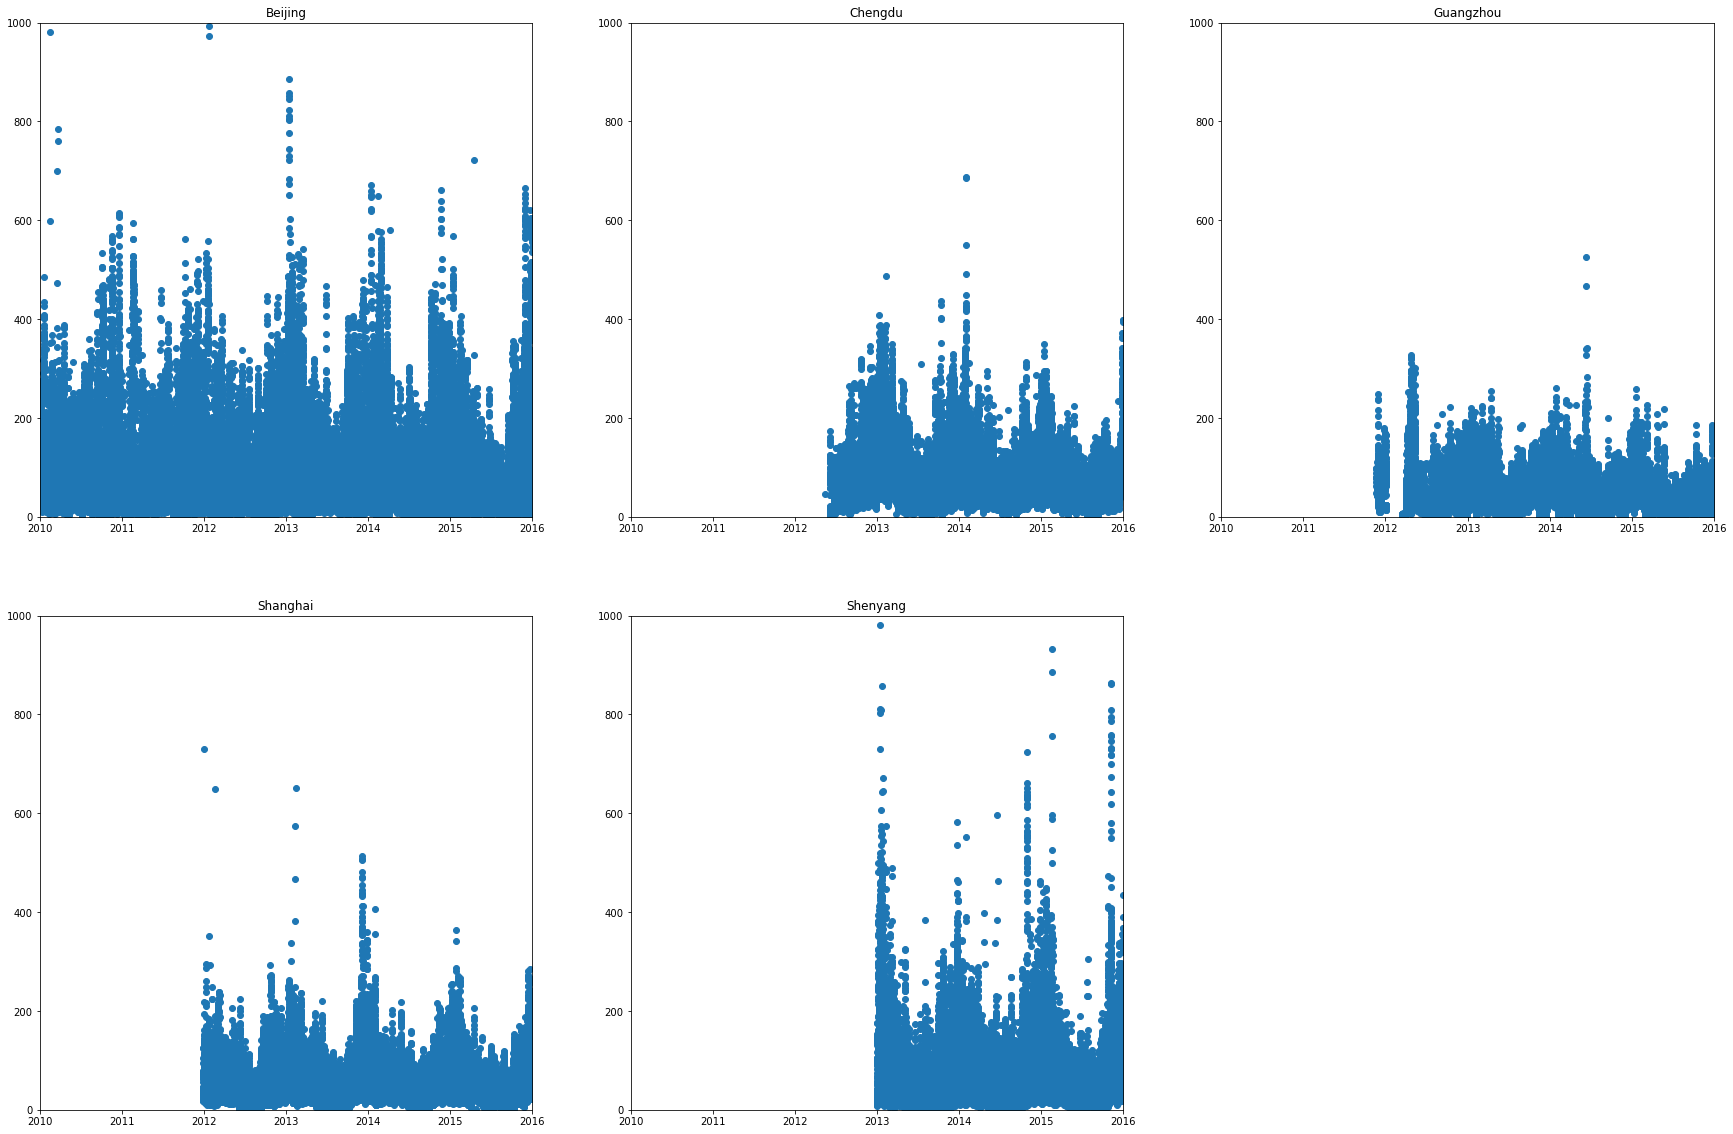

In [141]:
#Plot the dataset for a general overview of the data
fig, axs = plt.subplots(2, 3, figsize = (30,20))

axs[0][0].scatter(beijing.index, beijing['PM_US Post'],  label = 'Beijing')
axs[0][1].scatter(chengdu.index, chengdu['PM_US Post'], label = 'Chengdu')
axs[0][2].scatter(guangzhou.index, guangzhou['PM_US Post'], label = 'Guangzhou')
axs[1][0].scatter(shanghai.index, shanghai['PM_US Post'], label = 'Shanghai')
axs[1][1].scatter(shenyang.index, shenyang['PM_US Post'], label = 'Shenyang')

axs[0][0].set_xlim(pd.to_datetime('2010-01-01'), pd.to_datetime('2016-01-01'))
axs[0][1].set_xlim(pd.to_datetime('2010-01-01'), pd.to_datetime('2016-01-01'))
axs[0][2].set_xlim(pd.to_datetime('2010-01-01'), pd.to_datetime('2016-01-01'))
axs[1][0].set_xlim(pd.to_datetime('2010-01-01'), pd.to_datetime('2016-01-01'))
axs[1][1].set_xlim(pd.to_datetime('2010-01-01'), pd.to_datetime('2016-01-01'))

axs[0][0].set_ylim(0,1000)
axs[0][1].set_ylim(0,1000)
axs[0][2].set_ylim(0,1000)
axs[1][0].set_ylim(0,1000)
axs[1][1].set_ylim(0,1000)
                   
axs[0][0].title.set_text('Beijing')
axs[0][1].title.set_text('Chengdu')
axs[0][2].title.set_text('Guangzhou')
axs[1][0].title.set_text('Shanghai')
axs[1][1].title.set_text('Shenyang')

axs[-1, -1].axis('off')

plt.show()

The scatterplot shows for Beijing that the missing data is distributed arbitrarily. For Chengdu, Guangzhou and Shanghai the years 2010 - 2011 are missing. For Shenyang only values after the beginning of 2013 are available. Since there are PM2.5 values for every hour there are many data points. To get a clearer overview, hourly data is aggregated by day...

In [11]:
#Resample PM2.5 as daily average
beijing_day = beijing.drop(['year', 'month', 'day', 'hour', 'season', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'cbwd',
       'Iws', 'precipitation', 'Iprec','date'], axis = 1)
beijing_day = beijing_day.resample('D').mean()

chengdu_day = chengdu.drop(['year', 'month', 'day', 'hour', 'season',
       'DEWP', 'HUMI', 'PRES', 'TEMP', 'cbwd',
       'Iws', 'precipitation', 'Iprec','date'], axis = 1)
chengdu_day = chengdu_day.resample('D').mean()

guangzhou_day = guangzhou.drop(['year', 'month', 'day', 'hour', 'season', 
                               'DEWP', 'HUMI', 'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'Iprec','date'], axis = 1)
guangzhou_day = guangzhou_day.resample('D').mean()

shanghai_day = shanghai.drop(['year', 'month', 'day', 'hour', 'season', 
                               'DEWP', 'HUMI', 'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'Iprec','date'], axis = 1)
shanghai_day = shanghai_day.resample('D').mean()

shenyang_day = shenyang.drop(['year', 'month', 'day', 'hour', 'season', 
                               'DEWP', 'HUMI', 'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'Iprec','date'], axis = 1)
shenyang_day = shenyang.resample('D').mean()

...and the results plotted. Note the lowered y-axis limit of 600.

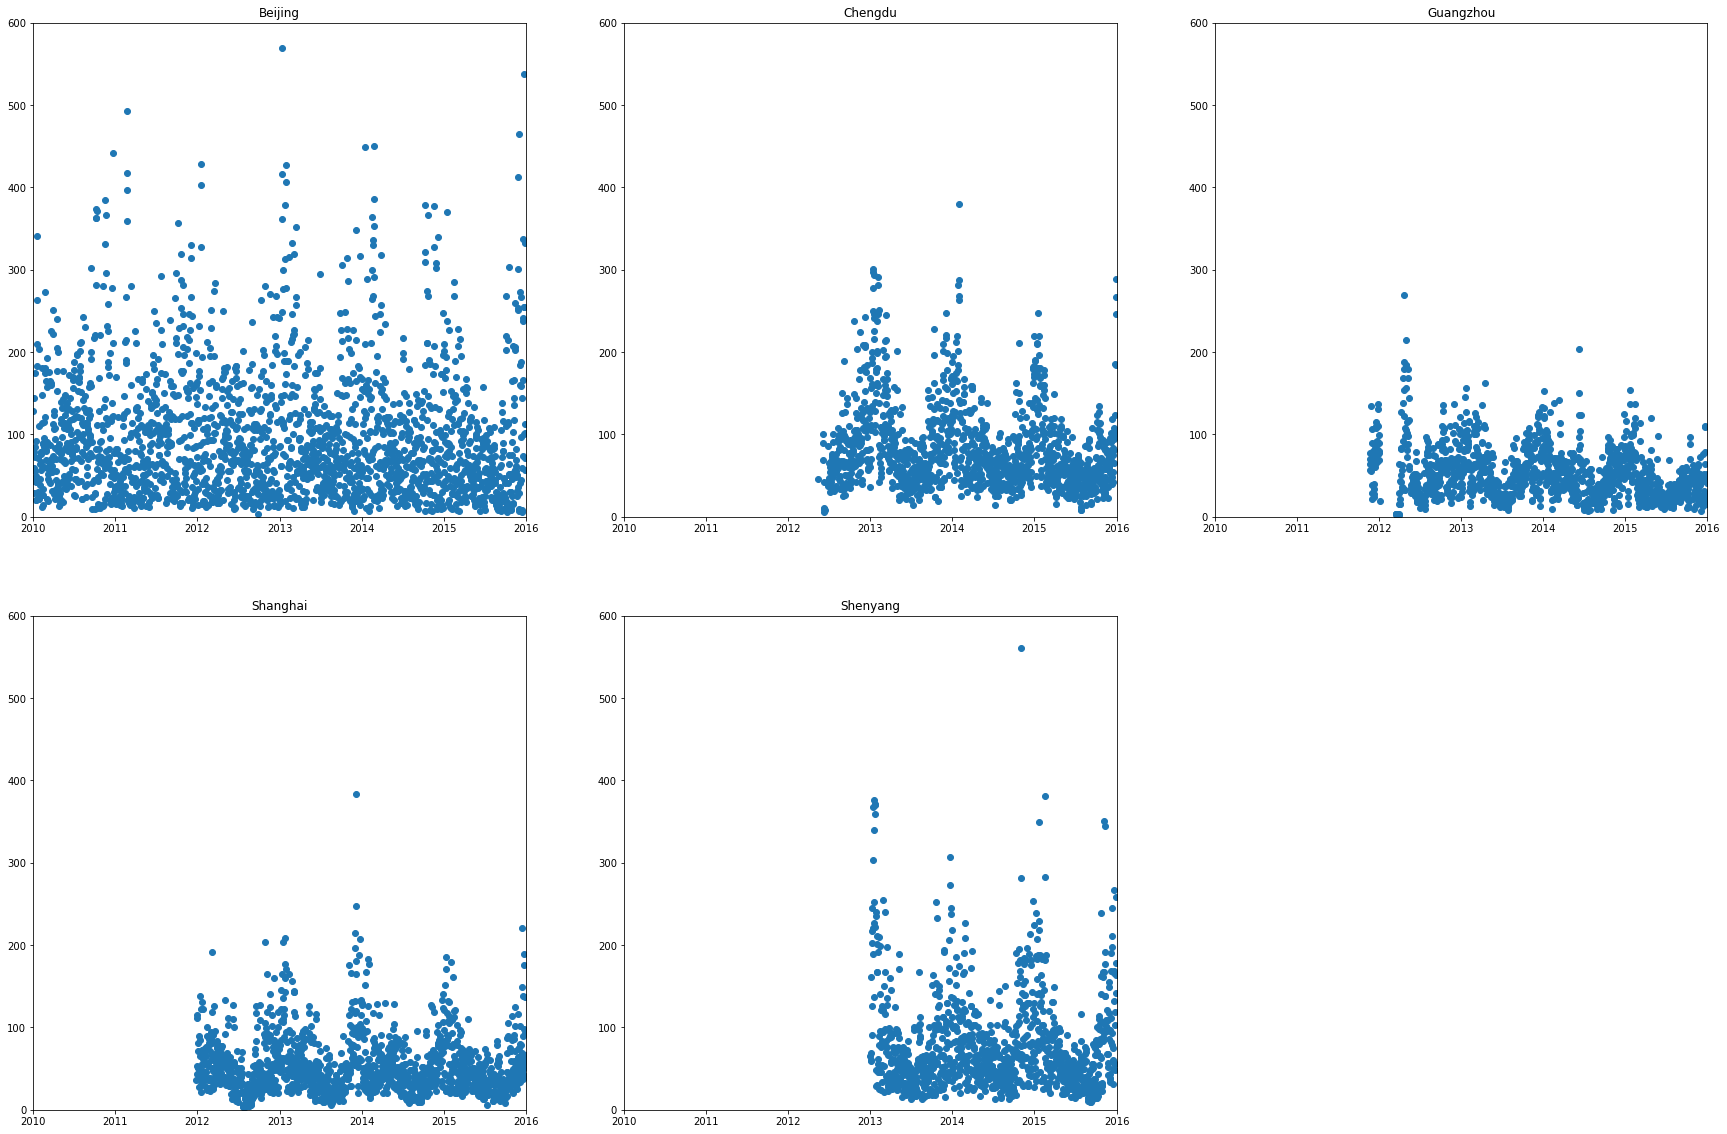

In [12]:
fig, axs = plt.subplots(2, 3, figsize = (30,20))

axs[0][0].scatter(beijing_day.index, beijing_day['PM_US Post'],  label = 'Beijing')
axs[0][1].scatter(chengdu_day.index, chengdu_day['PM_US Post'], label = 'Chengdu')
axs[0][2].scatter(guangzhou_day.index, guangzhou_day['PM_US Post'], label = 'Guangzhou')
axs[1][0].scatter(shanghai_day.index, shanghai_day['PM_US Post'], label = 'Shanghai')
axs[1][1].scatter(shenyang_day.index, shenyang_day['PM_US Post'], label = 'Shenyang')

axs[0][0].set_xlim(pd.to_datetime('2010-01-01'), pd.to_datetime('2016-01-01'))
axs[0][1].set_xlim(pd.to_datetime('2010-01-01'), pd.to_datetime('2016-01-01'))
axs[0][2].set_xlim(pd.to_datetime('2010-01-01'), pd.to_datetime('2016-01-01'))
axs[1][0].set_xlim(pd.to_datetime('2010-01-01'), pd.to_datetime('2016-01-01'))
axs[1][1].set_xlim(pd.to_datetime('2010-01-01'), pd.to_datetime('2016-01-01'))

axs[0][0].set_ylim(0,600)
axs[0][1].set_ylim(0,600)
axs[0][2].set_ylim(0,600)
axs[1][0].set_ylim(0,600)
axs[1][1].set_ylim(0,600)
                   
axs[0][0].title.set_text('Beijing')
axs[0][1].title.set_text('Chengdu')
axs[0][2].title.set_text('Guangzhou')
axs[1][0].title.set_text('Shanghai')
axs[1][1].title.set_text('Shenyang')

axs[-1, -1].axis('off')

plt.show()

Most daily means are between 0 and 300 for Chengdu, Guangzhou, Shanghai and Shenyang. Beijing has some higher values of up to over 500. The variation of the PM2.5 level is in general higher compared to the other four cities. It appears that the data varies seasonally over the course of the year, with high readings recurring at certain times of the year. Over the entire time course, there is not really a discernible trend in particular matter levels. A slight decrease can be interpreted into the scatter plots of Chengdu and Guangzhou, but hardly noticeable.  The decline corresponds to the trend of current measures to reduce (or at least to avoid increasing) particulate matter concentration levels in large cities.

In [13]:
#Find start and end date of the measures...
beijing_start = beijing.loc[beijing['PM_US Post'].notna()].date.min()
beijing_end = beijing.loc[beijing['PM_US Post'].notna()].date.max()
chengdu_start = chengdu.loc[chengdu['PM_US Post'].notna()].date.min()
chengdu_end = chengdu.loc[chengdu['PM_US Post'].notna()].date.max()
guangzhou_start = guangzhou.loc[guangzhou['PM_US Post'].notna()].date.min()
guangzhou_end = guangzhou.loc[guangzhou['PM_US Post'].notna()].date.max()
shanghai_start = shanghai.loc[shanghai['PM_US Post'].notna()].date.min()
shanghai_end = shanghai.loc[shanghai['PM_US Post'].notna()].date.max()
shenyang_start = shenyang.loc[shenyang['PM_US Post'].notna()].date.min()
shenyang_end = shenyang.loc[shenyang['PM_US Post'].notna()].date.max()

#... and only use date between start and end date
dates_beijing = (beijing['date'] >= beijing_start) & (beijing['date'] < beijing_end)
beijing = beijing.loc[dates_beijing]
dates_chengdu = (chengdu['date'] >= chengdu_start) & (chengdu['date'] < chengdu_end)
chengdu = chengdu.loc[dates_chengdu]
dates_guangzhou = (guangzhou['date'] >= guangzhou_start) & (guangzhou['date'] < guangzhou_end)
guangzhou = guangzhou.loc[dates_guangzhou]
dates_shanghai = (shanghai['date'] >= shanghai_start) & (shanghai['date'] < shanghai_end)
shanghai = shanghai.loc[dates_shanghai]
dates_shenyang = (shenyang['date'] >= shenyang_start) & (shenyang['date'] < shenyang_end)
shenyang = shenyang.loc[dates_shenyang]

In [14]:
df_isna = pd.DataFrame({'beijing':beijing.isna().sum(),
                        'chengdu':chengdu.isna().sum(), 
                        'guangzhou':guangzhou.isna().sum(),
                        'shanghai':shanghai.isna().sum(),
                        'shenyang':shenyang.isna().sum()}, index = ['year', 'month', 'day', 'hour', 'season','PM_US Post', 'DEWP', 'HUMI', 
                        'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'Iprec'])

df_isna

,beijing,chengdu,guangzhou,shanghai,shenyang
year,0,0,0,0,0
month,0,0,0,0,0
day,0,0,0,0,0
hour,0,0,0,0,0
season,0,0,0,0,0
PM_US Post,1871,1332,2662,347,395
DEWP,5,492,0,5,4
HUMI,339,496,0,5,4
PRES,339,486,0,20,4
TEMP,5,490,0,5,4


## 2.1 Missing Values

This already looks way better than the dataframe in the beginning. Still there are missing values for the US Post PM2.5 measurements. In the following three approaches are presented to account for the missing values. First, the trivial approach of simply dropping the rows with missing values for US Post. Second, by replacing the missing values with the daily average. The second approach, however, holds some serious drawbacks, as valuable information might get lost, when values are simply replaced by their average. For Chengdu the values vary between 20 and 125 on 16th of August 2013, which is a lot considering an average of 83 over the entire record. Rows contain missing values if no data is available for the entire day and thus no daily average can be calculated. Respective rows are dropped.
Third, by interpolating linear between the preceding and sucessive data point.
The equally spaced measurements are replaced by their interpolation for a maximum of two consecutive measures. Remaining rows containing missing values for target PM_US Post are dropped. The method for replacing missing values that performs best in the benchmark model will be used for the machine learning modell in chapter 4.

In [15]:
chengdu['PM_US Post'].mean()

83.22428772827121

### Option 1: Drop Rows with missing values

In [16]:
#Method to simply drop rows with missing values
def drop_val(df, col_name):
    df_d = df[df[col_name].notna()]
    return df_d

In [17]:
beijing_d = drop_val(beijing, 'PM_US Post')
chengdu_d = drop_val(chengdu, 'PM_US Post')
guangzhou_d = drop_val(guangzhou, 'PM_US Post')
shanghai_d = drop_val(shanghai, 'PM_US Post')
shenyang_d = drop_val(shenyang, 'PM_US Post')

# beijing_d.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/beijing_d.csv')
# chengdu_d.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/chengdu_d.csv')
# guangzhou_d.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/guangzhou_d.csv')
# shanghai_d.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/shanghai_d.csv')
# shenyang_d.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/shenyang_d.csv')

### Option 2: Daily Mean

In [18]:
#method to replace missing values with daily mean for list of columns
#only replace missing numerical values
def calculate_dailymean(df, col_list):
    df_day = df[col_list].copy()
    df_day = df_day.resample('D').mean()
    
    #since the resampled data only contains the day because we calculated the daily mean
    df['date_day'] = pd.to_datetime(df['year'].astype(str) +'-'+ df['month'].astype(str) +'-'+ df['day'].astype(str), format = '%Y-%m-%d')
    
    for col in col_list:
        df[col + '_avg'] = 0
        
    for index, row in df.iterrows():
        for col in col_list:
            df.loc[index, col + '_avg'] = df_day.loc[row['date_day']][col]
            
    for col in col_list:
        df[col].fillna(df[col + '_avg'], inplace = True)
    
    return df

In [19]:
#==============================
#Takes some time: finished dataset 'beijing_m' can be imported instead 
#==============================

# #Do not calculate mean for wind direction since it is non-numerical
# beijing_m = calculate_dailymean(beijing.copy(), ['PM_US Post', 'DEWP', 'HUMI', 'PRES', 'TEMP',
#        'Iws', 'precipitation', 'Iprec'])

# chengdu_m = calculate_dailymean(chengdu.copy(), ['PM_US Post', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'Iws',
#        'precipitation', 'Iprec'])

# guangzhou_m = calculate_dailymean(guangzhou.copy(), ['PM_US Post', 'DEWP', 'HUMI', 'PRES', 'TEMP',
#         'Iws', 'precipitation', 'Iprec'])

# shanghai_m = calculate_dailymean(shanghai.copy(),['PM_US Post','DEWP', 'HUMI', 'PRES', 'TEMP', 'Iws',
#        'precipitation', 'Iprec'])

# shenyang_m = calculate_dailymean(shenyang.copy(), ['PM_US Post','DEWP', 'HUMI', 'PRES', 'TEMP', 'Iws',
#        'precipitation', 'Iprec'])

In [20]:
# #Drop Rows with missing measures for the whole day
# beijing_m = drop_val(beijing_m, 'PM_US Post')
# chengdu_m = drop_val(chengdu_m, 'PM_US Post')
# guangzhou_m = drop_val(guangzhou_m, 'PM_US Post')
# shanghai_m = drop_val(shanghai_m, 'PM_US Post')
# shenyang_m = drop_val(shenyang_m, 'PM_US Post')

# #Drop Columns with daily mean values
# beijing_m = beijing_m.drop(['PM_US Post_avg', 'DEWP_avg', 'HUMI_avg', 'PRES_avg',
#        'TEMP_avg', 'Iws_avg', 'precipitation_avg', 'Iprec_avg','date_day'], axis = 1)
# chengdu_m = chengdu_m.drop(['PM_US Post_avg', 'DEWP_avg', 'HUMI_avg', 'PRES_avg',
#        'TEMP_avg', 'Iws_avg', 'precipitation_avg', 'Iprec_avg','date_day'], axis = 1)
# guangzhou_m = guangzhou_m.drop(['PM_US Post_avg', 'DEWP_avg', 'HUMI_avg', 'PRES_avg',
#        'TEMP_avg', 'Iws_avg', 'precipitation_avg', 'Iprec_avg','date_day'], axis = 1)
# shanghai_m = shanghai_m.drop(['PM_US Post_avg', 'DEWP_avg', 'HUMI_avg', 'PRES_avg',
#        'TEMP_avg', 'Iws_avg', 'precipitation_avg', 'Iprec_avg','date_day'], axis = 1)
# shenyang_m = shenyang_m.drop(['PM_US Post_avg', 'DEWP_avg', 'HUMI_avg', 'PRES_avg',
#        'TEMP_avg', 'Iws_avg', 'precipitation_avg', 'Iprec_avg','date_day'], axis = 1)

In [21]:
# beijing_m.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/beijing_m.csv')
# chengdu_m.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/chengdu_m.csv')
# guangzhou_m.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/guangzhou_m.csv')
# shanghai_m.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/shanghai_m.csv')
# shenyang_m.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/shenyang_m.csv')

### Option 3: Interpolate

In [22]:
#method to interpolate missing values
def interpol_cols(df, cols):
    for col in cols:
        df[col].interpolate(method = 'linear',limit=3,inplace=True)
    return df

In [23]:
beijing_ip = interpol_cols(beijing.copy(),['PM_US Post', 'DEWP', 'HUMI', 'PRES', 'TEMP',
                                           'Iws', 'precipitation', 'Iprec'])
chengdu_ip = interpol_cols(chengdu.copy(), ['PM_US Post', 'DEWP', 'HUMI', 'PRES',
                                            'TEMP', 'Iws','precipitation', 'Iprec'])
guangzhou_ip = interpol_cols(guangzhou.copy(), ['PM_US Post', 'DEWP',
                                                'HUMI', 'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'Iprec'])
shanghai_ip = interpol_cols(shanghai.copy(),['PM_US Post', 'DEWP', 'HUMI', 'PRES', 'TEMP',
                                             'Iws', 'precipitation', 'Iprec'] )
shenyang_ip = interpol_cols(shenyang.copy(), ['PM_US Post', 'DEWP', 'HUMI', 
                                              'PRES', 'TEMP', 'Iws','precipitation', 'Iprec'] )

In [24]:
#Drop rows with missing entries for Target
beijing_ip = drop_val(beijing_ip, 'PM_US Post')
chengdu_ip = drop_val(chengdu_ip, 'PM_US Post')
guangzhou_ip = drop_val(guangzhou_ip, 'PM_US Post')
shanghai_ip = drop_val(shanghai_ip, 'PM_US Post')
shenyang_ip = drop_val(shenyang_ip, 'PM_US Post')

# beijing_ip.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/beijing_ip.csv')
# chengdu_ip.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/chengdu_ip.csv')
# guangzhou_ip.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/guangzhou_ip.csv')
# shanghai_ip.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/shanghai_ip.csv')
# shenyang_ip.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/shenyang_ip.csv')

In [27]:
data_dir = '/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/'

In [28]:
#Reimport of Option 1
beijing_d = pd.read_csv(data_dir + 'beijing_d.csv',index_col = 0)
chengdu_d = pd.read_csv(data_dir + 'chengdu_d.csv',index_col = 0)
guangzhou_d = pd.read_csv(data_dir + 'guangzhou_d.csv',index_col = 0)
shanghai_d = pd.read_csv(data_dir + 'shanghai_d.csv',index_col = 0)
shenyang_d = pd.read_csv(data_dir +'shenyang_d.csv', index_col = 0)

#Reimport of Option 2
beijing_m = pd.read_csv(data_dir + 'beijing_m.csv',index_col = 0)
chengdu_m = pd.read_csv(data_dir + 'chengdu_m.csv',index_col = 0)
guangzhou_m = pd.read_csv(data_dir + 'guangzhou_m.csv',index_col = 0)
shanghai_m = pd.read_csv(data_dir + 'shanghai_m.csv',index_col = 0)
shenyang_m = pd.read_csv(data_dir +'shenyang_m.csv', index_col = 0)

#Reimport of Option 3
beijing_ip = pd.read_csv(data_dir + 'beijing_ip.csv',index_col = 0)
chengdu_ip = pd.read_csv(data_dir + 'chengdu_ip.csv',index_col = 0)
guangzhou_ip = pd.read_csv(data_dir + 'guangzhou_ip.csv',index_col = 0)
shanghai_ip = pd.read_csv(data_dir + 'shanghai_ip.csv',index_col = 0)
shenyang_ip = pd.read_csv(data_dir +'shenyang_ip.csv', index_col = 0)

In [29]:
#guangzhou season column is in float instead of int
guangzhou_d['season'] = guangzhou_d['season'].astype(int)
guangzhou_m['season'] = guangzhou_d['season'].astype(int)
guangzhou_ip['season'] = guangzhou_d['season'].astype(int)

Previous three methods reduced the number of missing values. Further remaining rows with missing values are dropped.

In [30]:
beijing_d = beijing_d.dropna(axis = 0)
beijing_m = beijing_m.dropna(axis = 0)
beijing_ip = beijing_ip.dropna(axis = 0)

chengdu_d = chengdu_d.dropna(axis = 0)
chengdu_m = chengdu_m.dropna(axis = 0)
chengdu_ip = chengdu_ip.dropna(axis = 0)

guangzhou_d = guangzhou_d.dropna(axis = 0)
guangzhou_m = guangzhou_m.dropna(axis = 0)
guangzhou_ip = guangzhou_ip.dropna(axis = 0)

shanghai_d = shanghai_d.dropna(axis = 0)
shanghai_m = shanghai_m.dropna(axis = 0)
shanghai_ip = shanghai_ip.dropna(axis = 0)

shenyang_d = shenyang_d.dropna(axis = 0)
shenyang_m = shenyang_m.dropna(axis = 0)
shenyang_ip = shenyang_ip.dropna(axis = 0)

In [31]:
from tabulate import tabulate

print(tabulate([['Beijing', len(beijing_d),len(beijing_m),len(beijing_ip)],
                ['Chengdu', len(chengdu_d),len(chengdu_m),len(chengdu_ip)],
                ['Guangzhou', len(guangzhou_d),len(guangzhou_m),len(guangzhou_ip)],
                ['Shanghai', len(shanghai_d),len(shanghai_m),len(shanghai_ip)],
                ['Shenyang', len(shenyang_d),len(shenyang_m),len(shenyang_ip)]],
                headers=['City', 'drop', 'mean', 'interpolate'], tablefmt='orgtbl',floatfmt = [None, '.0f','.0f','.0f']))

| City      |   drop |   mean |   interpolate |
|-----------+--------+--------+---------------|
| Beijing   |  49870 |  51236 |         50330 |
| Chengdu   |  28778 |  29692 |         29276 |
| Guangzhou |  33372 |  33372 |         33372 |
| Shanghai  |  32505 |  34057 |         33485 |
| Shenyang  |  24409 |  25363 |         25059 |


The table shows that the three preprocessing methods do not change the number of observations much. Often, if one observation is missing, all observations for this day are missing. Or at least many consecutive observation are missing. The benchmark model is used which preprocessing method performs best. In order to do so, categorical variables must be encoded first.

## 2.2 Encoding categorical variables

In [32]:
beijing_d.dtypes

year               int64
month              int64
day                int64
hour               int64
season             int64
PM_US Post       float64
DEWP             float64
HUMI             float64
PRES             float64
TEMP             float64
cbwd              object
Iws              float64
precipitation    float64
Iprec            float64
date              object
dtype: object

Except wind direction (cbwd) and season all variables are numerical (date omitted). Not all machine learning models can handle categorical variables and encoding them in a useful way is necessary. 
This report sticks to One-Hot-Encoding due to its binary nature without imposing some ordinality (as Label-Encoding) and the benefit of placing the categories inside an orthogonal vector space (NB7_Bonus Exercise, Introduction to Statistical Machine Learning, Acess: September 30th 2021).

In [33]:
print('Beijing number of wind directions: ' + str(beijing_d.cbwd.nunique()) )
print('Chengdu number of wind directions: ' + str(chengdu_d.cbwd.nunique()) )
print('Guangzhou number of wind directions: ' + str(guangzhou_d.cbwd.nunique()) )
print('Shanghai number of wind directions: ' + str(shanghai_d.cbwd.nunique()) )
print('Shenyang number of wind directions: ' + str(shenyang_d.cbwd.nunique()) )

Beijing number of wind directions: 4
Chengdu number of wind directions: 5
Guangzhou number of wind directions: 5
Shanghai number of wind directions: 5
Shenyang number of wind directions: 5


There is a maximum of five different wind directions per city, so one hot-encoding should work well.

In [34]:
#Method to perform the one-hot encoding
def encode(df, col):
    df_enc = pd.get_dummies(df[col].astype(str), prefix=None, dummy_na=False)
    df.drop(col, axis = 1, inplace = True)
    return pd.concat([df, df_enc], axis = 1)

In [35]:
beijing_d = encode(beijing_d.copy(), ['cbwd','season'])
beijing_m = encode(beijing_m.copy(), ['cbwd','season'])
beijing_ip = encode(beijing_ip.copy(), ['cbwd','season'])

chengdu_d = encode(chengdu_d.copy(), ['cbwd','season'])
chengdu_m = encode(chengdu_m.copy(), ['cbwd','season'])
chengdu_ip = encode(chengdu_ip.copy(), ['cbwd','season'])

guangzhou_d = encode(guangzhou_d.copy(),['cbwd','season'])
guangzhou_m = encode(guangzhou_m.copy(),['cbwd','season'])
guangzhou_ip = encode(guangzhou_ip.copy(),['cbwd','season'])

shanghai_d = encode(shanghai_d.copy(),['cbwd','season'])
shanghai_m = encode(shanghai_m.copy(),['cbwd','season'])
shanghai_ip = encode(shanghai_ip.copy(),['cbwd','season'])

shenyang_d = encode(shenyang_d.copy(),['cbwd','season'])
shenyang_m = encode(shenyang_m.copy(),['cbwd','season'])
shenyang_ip = encode(shenyang_ip.copy(),['cbwd','season'])

## 2.3 Correlation

The correlation between the target variable 'PM_US Post' is calculated. For every city this is done with the dataset that simply drops rows with missing values. By changig the suffix (to m or ip) one can see that this yields only minor changes regarding the correlation. 

In [36]:
corr_beijing = beijing_d.corr()['PM_US Post']
print(corr_beijing[np.argsort(corr_beijing, axis=0)[::-1]])

PM_US Post       1.000000
HUMI             0.420422
cbwd_cv          0.171199
DEWP             0.132477
season_4         0.113902
cbwd_SE          0.111066
day              0.077774
season_3         0.027463
hour            -0.000846
month           -0.011359
PRES            -0.017948
precipitation   -0.026974
cbwd_NE         -0.032893
Iprec           -0.043473
year            -0.054940
season_1        -0.065548
season_2        -0.075257
TEMP            -0.124925
Iws             -0.240508
cbwd_NW         -0.241852
Name: PM_US Post, dtype: float64


In [37]:
corr_chengdu = chengdu_d.corr()['PM_US Post']
print(corr_chengdu[np.argsort(corr_chengdu, axis=0)[::-1]])

PM_US Post       1.000000
season_4         0.434821
PRES             0.250540
cbwd_cv          0.159077
HUMI             0.130373
day              0.053108
cbwd_NW         -0.021190
season_1        -0.041719
cbwd_SW         -0.059568
cbwd_SE         -0.060678
hour            -0.065020
precipitation   -0.071054
Iprec           -0.097108
season_3        -0.098153
cbwd_NE         -0.110781
year            -0.128819
month           -0.167645
Iws             -0.191672
season_2        -0.287582
DEWP            -0.316917
TEMP            -0.401707
Name: PM_US Post, dtype: float64


In [38]:
corr_guangzhou = guangzhou_d.corr()['PM_US Post']
print(corr_guangzhou[np.argsort(corr_guangzhou, axis=0)[::-1]])

PM_US Post       1.000000
season_4         0.235320
PRES             0.221437
cbwd_NW          0.135284
season_1         0.045739
hour             0.033553
day              0.022233
season_3         0.008575
cbwd_cv          0.004835
HUMI            -0.007078
cbwd_NE         -0.009899
DEWP            -0.016474
month           -0.071804
precipitation   -0.074073
cbwd_SE         -0.086012
cbwd_SW         -0.090349
Iws             -0.098573
Iprec           -0.111018
year            -0.204827
TEMP            -0.216361
season_2        -0.281755
Name: PM_US Post, dtype: float64


In [39]:
corr_shanghai = shanghai_d.corr()['PM_US Post']
print(corr_shanghai[np.argsort(corr_shanghai, axis=0)[::-1]])

PM_US Post       1.000000
season_4         0.310946
cbwd_NW          0.271354
PRES             0.261442
cbwd_SW          0.096436
cbwd_cv          0.094456
season_1         0.033788
hour             0.014341
day             -0.018121
year            -0.026155
month           -0.065074
precipitation   -0.074088
HUMI            -0.083484
season_3        -0.093310
Iprec           -0.096632
cbwd_SE         -0.148324
cbwd_NE         -0.177843
Iws             -0.199368
season_2        -0.261214
TEMP            -0.320524
DEWP            -0.328599
Name: PM_US Post, dtype: float64


In [40]:
corr_shenyang = shenyang_d.corr()['PM_US Post']
print(corr_shenyang[np.argsort(corr_shenyang, axis=0)[::-1]])

PM_US Post       1.000000
PRES             0.350588
season_4         0.326273
HUMI             0.198508
cbwd_NE          0.117876
cbwd_SE          0.103107
day              0.095798
cbwd_cv          0.079274
season_3        -0.001407
precipitation   -0.032537
year            -0.041310
Iprec           -0.058011
month           -0.067219
hour            -0.073099
cbwd_SW         -0.092751
Iws             -0.094307
season_1        -0.094832
cbwd_NW         -0.162975
season_2        -0.236489
DEWP            -0.263666
TEMP            -0.373166
Name: PM_US Post, dtype: float64


The correlation of the different features with the target variable is rather low. The order differs through the cities. In general 'pressure' (pres) and 'season' are higher positively correlated. Lower negatively correlated predictors are 'temperature' (TEMP) and 'dew point' (DEWP), except for beijing where the dew point is even positively correlated.
The pairwise correlation of individual characteristics is considered below. High correlation between features can lead to less robust models. Results are displayed for Shenyang. Other cities yield similar results. (Code from NB7_Bonus Exercise, Introduction to Statistical Machine Learning, Sebastian Lerch, Acess: August 18th 21).

In [41]:
#without target
shenyang_nt = shenyang_d.drop('PM_US Post', axis = 1)
correlations = shenyang_d.corr()

# threshold to cut away smaller correlations (optional)
threshold = 0.6
correlations_thresholded = (correlations[abs(correlations) > threshold]
                            [correlations != 1.0]).unstack().dropna().to_dict()

unique_pairwise_correlations = pd.DataFrame(
  list(set([(tuple(sorted(key)), correlations_thresholded[key]) 
            for key in correlations_thresholded])), 
  columns=['Variable Pair', 'Correlation'])

# sort list by absolute value in decreasing order
unique_pairwise_correlations = unique_pairwise_correlations.iloc[
  abs(unique_pairwise_correlations['Correlation']).argsort()[::-1]]

print(unique_pairwise_correlations)

      Variable Pair  Correlation
6      (DEWP, TEMP)     0.898420
3      (DEWP, PRES)    -0.796701
1      (PRES, TEMP)    -0.794882
7  (TEMP, season_4)    -0.724646
5  (DEWP, season_2)     0.692061
2  (DEWP, season_4)    -0.658946
0  (TEMP, season_2)     0.607364
4  (PRES, season_2)    -0.602924


Overall, the number of strongly correlated features is limited. The highest (positive) correlation is between dew point and temperature, which makes sense since the dew point is directly dependent on the air temperature. Conversely, the lowest (negative) correlation is between dew point and air pressure, and air pressure and temperature. This correlation can also be easily understood. Since not many parameters are strongly correlated a robust model is expected.

## 2.4 Split into Train/Valid/Test and Normalize

The goal of this report is to design a model to predict PM2.5 concentration depending on weather forecasts in order to propose daily actions. In a real world example the data would be in the future, so we cannot verify how good the model is in advance. To simulate real world conditions a part of the dataset is withhold and used as a test data. Aurélien and Géron (2019, p. 31) recommend a split of 80% training data to 20% test data. Achieving this split is challenging, because the data of the five cities ranges differently and contains missing data. So choosing the same date for all cities is not an exact 80-to-20 split. For the purpose of real world conditions, data before April 1st 2015 is considered training data. Data starting April 1st until December 2015 is test data. See below for share sizes.

Since it is not recommended to use training data for evaluating the model, a third dataset is necessary, the validation set. Therefore the training data is split into data used for training (training set) and data used for validation (validation data). To prevent confusion henceforth the term training data denotes training set and validation set. Test data denotes the data set used for testing.
Regarding the above mentioned recommendation, the 1st of October 2014 splits the training data into test set and validation set. Especially for Beijing the shares are smaller and Shenyang bigger, whereas they are the largest and smallest datasets after preprocessing.

Many machine learning algorithms require normalized data. Also the variables 'year', 'month', 'day', 'hour','date' are dropped. Even though these variables could be useful, but require further consideration and are non-continuous. Categorical data like season and wind direction are not normalized.

In [42]:
#Drop unnecessary columns
beijing_d = beijing_d.drop(['year', 'month', 'day', 'hour', 'date'], axis = 1)
beijing_m = beijing_m.drop(['year', 'month', 'day', 'hour', 'date'], axis = 1)
beijing_ip = beijing_ip.drop(['year', 'month', 'day', 'hour', 'date'], axis = 1)

chengdu_d = chengdu_d.drop(['year', 'month', 'day', 'hour', 'date'], axis = 1)
chengdu_m = chengdu_m.drop(['year', 'month', 'day', 'hour', 'date'], axis = 1)
chengdu_ip = chengdu_ip.drop(['year', 'month', 'day', 'hour', 'date'], axis = 1)

guangzhou_d = guangzhou_d.drop(['year', 'month', 'day', 'hour', 'date'], axis = 1)
guangzhou_m = guangzhou_m.drop(['year', 'month', 'day', 'hour', 'date'], axis = 1)
guangzhou_ip = guangzhou_ip.drop(['year', 'month', 'day', 'hour', 'date'], axis = 1)

shanghai_d = shanghai_d.drop(['year', 'month', 'day', 'hour', 'date'], axis = 1)
shanghai_m = shanghai_m.drop(['year', 'month', 'day', 'hour', 'date'], axis = 1)
shanghai_ip = shanghai_ip.drop(['year', 'month', 'day', 'hour', 'date'], axis = 1)

shenyang_d = shenyang_d.drop(['year', 'month', 'day', 'hour', 'date'], axis = 1)
shenyang_m = shenyang_m.drop(['year', 'month', 'day', 'hour', 'date'], axis = 1)
shenyang_ip = shenyang_ip.drop(['year', 'month', 'day', 'hour', 'date'], axis = 1)

In [43]:
# for city in [beijing_d,beijing_m,beijing_ip,
#             chengdu_d,chengdu_m,chengdu_ip,
#             guangzhou_d,guangzhou_m,guangzhou_ip,
#             shanghai_d,shanghai_m,shanghai_ip,
#             shenyang_d,shenyang_m,shenyang_ip]:
#     print(len(city.columns)

Method to split into train/valid/ test and normalize:

In [44]:
def split_tvt(df, test_split, val_split, cat_col):
    
    #split
    df_train = df[pd.to_datetime(df.index) < pd.to_datetime(test_split)]
    df_test = df[pd.to_datetime(df.index) >= pd.to_datetime(test_split)]
    
    #drop cat columns
    df_train_num = df_train.drop(cat_col, axis = 1)
    df_train_cat = df_train[cat_col]

    df_test_num = df_test.drop(cat_col, axis = 1)
    df_test_cat = df_test[cat_col]
    
    #normalize numerous variables except for target variable PM_US Post
    df_train_num_X = df_train_num.drop('PM_US Post', axis = 1)
    df_train_num_y = df_train_num['PM_US Post']
    
    df_test_num_X = df_test_num.drop('PM_US Post', axis = 1)
    df_test_num_y = df_test_num['PM_US Post']
    
    df_train_num_X = (df_train_num_X - df_train_num_X.mean()) / df_train_num_X.std()
    df_test_num_X = (df_test_num_X - df_test_num_X.mean()) / df_test_num_X.std()
    
    #add categorical columns again
    df_train = pd.concat([df_train_num_y, df_train_num_X, df_train_cat], axis = 1)
    df_test = pd.concat([df_test_num_y, df_test_num_X, df_test_cat], axis = 1)
    
    #split into train and validation set
    df_tr = df_train[pd.to_datetime(df_train.index) <= pd.to_datetime(val_split)]
    df_val = df_train[pd.to_datetime(df_train.index) > pd.to_datetime(val_split)]
    
    return df_tr, df_val, df_test

Split a the above mentioned date for all five cities and the three alternative ways of replacing missing values:

In [45]:
#Date for split into test and training data
test_spl='2015-04-01'

#Date for split into training and validation set
val_spl='2014-10-01'
cat_columns = ['cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'season_1',
       'season_2', 'season_3', 'season_4']

beijing_d_tr, beijing_d_val, beijing_d_test = split_tvt(beijing_d, test_spl, val_spl, cat_columns)
beijing_m_tr, beijing_m_val, beijing_m_test = split_tvt(beijing_m, test_spl, val_spl, cat_columns)
beijing_ip_tr, beijing_ip_val, beijing_ip_test = split_tvt(beijing_ip, test_spl, val_spl, cat_columns)

chengdu_d_tr, chengdu_d_val, chengdu_d_test = split_tvt(chengdu_d, test_spl, val_spl, cat_columns)
chengdu_m_tr, chengdu_m_val, chengdu_m_test = split_tvt(chengdu_m, test_spl, val_spl, cat_columns)
chengdu_ip_tr, chengdu_ip_val, chengdu_ip_test = split_tvt(chengdu_ip, test_spl, val_spl, cat_columns)

guangzhou_d_tr, guangzhou_d_val, guangzhou_d_test = split_tvt(guangzhou_d, test_spl, val_spl, cat_columns)
###columns of guangzhou are named different
guangzhou_m['season_1'] = guangzhou_m['season_1.0']
guangzhou_m['season_2'] = guangzhou_m['season_2.0']
guangzhou_m['season_3'] = guangzhou_m['season_3.0']
guangzhou_m['season_4'] = guangzhou_m['season_4.0']
guangzhou_m.drop(['season_1.0', 'season_2.0', 'season_3.0', 'season_4.0'], axis = 1, inplace = True)
guangzhou_ip['season_1'] = guangzhou_ip['season_1.0']
guangzhou_ip['season_2'] = guangzhou_ip['season_2.0']
guangzhou_ip['season_3'] = guangzhou_ip['season_3.0']
guangzhou_ip['season_4'] = guangzhou_ip['season_4.0']
guangzhou_ip.drop(['season_1.0', 'season_2.0', 'season_3.0', 'season_4.0'], axis = 1, inplace = True)
###
guangzhou_m_tr, guangzhou_m_val, guangzhou_m_test = split_tvt(guangzhou_m, test_spl, val_spl, cat_columns)
guangzhou_ip_tr, guangzhou_ip_val, guangzhou_ip_test = split_tvt(guangzhou_ip, test_spl, val_spl, cat_columns)

shanghai_d_tr, shanghai_d_val, shanghai_d_test = split_tvt(shanghai_d, test_spl, val_spl, cat_columns)
shanghai_m_tr, shanghai_m_val, shanghai_m_test = split_tvt(shanghai_m, test_spl, val_spl, cat_columns)
shanghai_ip_tr, shanghai_ip_val, shanghai_ip_test = split_tvt(shanghai_ip, test_spl, val_spl, cat_columns)

shenyang_d_tr, shenyang_d_val, shenyang_d_test = split_tvt(shenyang_d, test_spl, val_spl, cat_columns)
shenyang_m_tr, shenyang_m_val, shenyang_m_test = split_tvt(shenyang_m, test_spl, val_spl, cat_columns)
shenyang_ip_tr, shenyang_ip_val, shenyang_ip_test = split_tvt(shenyang_ip, test_spl, val_spl, cat_columns)

Show proportions of test and validation set:

In [46]:
city_names = ['Beijing', 'Chengdu', 'Guangzhou', 'Shanghai','Shenyang']

#proportion of test data in total data
proportion_test_set = [len(beijing_d_test)/len(beijing_d),len(chengdu_d_test)/len(chengdu_d),len(guangzhou_d_test)/len(guangzhou_d),len(shanghai_d_test)/len(shanghai_d),len(shenyang_d_test)/len(shenyang_d)]

#proportion of in validation set in training data
proportion_val_set = [len(beijing_d_val)/len(beijing_d_tr),len(chengdu_d_val)/len(chengdu_d_tr),len(guangzhou_d_val)/len(guangzhou_d_tr),len(shanghai_d_val)/len(shanghai_d_tr),len(shenyang_d_val)/len(shenyang_d_tr)]

for i in range(0,5):
    print(city_names[i])
    print('proportion of test set: ' + str(round(proportion_test_set[i], 2)) + ', proportion of validation set: ' + str(round(proportion_val_set[i],2)))

Beijing
proportion of test set: 0.12, proportion of validation set: 0.11
Chengdu
proportion of test set: 0.22, proportion of validation set: 0.23
Guangzhou
proportion of test set: 0.2, proportion of validation set: 0.19
Shanghai
proportion of test set: 0.16, proportion of validation set: 0.19
Shenyang
proportion of test set: 0.25, proportion of validation set: 0.29


## 2.5 Performance Measures: MSE and $R^{2}$

The last step in the second chapter is to find a suitable performance measure for the task and target variable presented. A performance measure typically used for regression problems is the Mean-Squared-Error ($MSE$). It gives an idea of how many errors the system typically makes in its predictions, with large errors being weighted more heavily (Aurélien and Géron, 2019, p. 42).

$MSE(X,h) = \frac{1}{n} \sum_{i=1}^{n} (h(x^{(i)}) - y^{(i)})^2 $

with $n$ being the number of observations in the dataset the $MSE$ is measured on. $x^{i}$ is the feature vector (without labels) of the $i^{th}$ observation and $y^{(i)}$ its label.

In [47]:
#Compute mse
def mse(y_true, y_pred): return ((y_true - y_pred)**2).mean()

As a second performance measure the $R^{2}$, a common metric in statistics is used (https://en.wikipedia.org/wiki/Coefficient_of_determination, last acess: August 30th 2021).

$R^{2}$ = $\frac{ESS}{TSS}$ = 
$1 - \frac{\sum_{i=1}^{n} (y^{(i)} - h(x^{(i)}) )^{2}}{\sum_{i=1}^{n}(y^{(i)} - \overline{y})^{2}}$

$\overline{y}$ is the mean of the estimated values, $ESS$ the explained sum of squares and $TSS$ Total sum of squares. $R^{2}$ is a dimensionless measure that expresses the proportion of variability  of the dependent variable that is explained by the linear model. 

# 3. Benchmark model

A reference model is important to evaluate the machine learning models implemented. The dataset itself does not provide a benchmark forecast. Therefore a simple multiple linear regression model is used as a benchmark model. The dataset consists of mostly numerical continous variables and two dummy variables. For those reasons a multiple linear regression model seems appropriate. As mentioned before the benchmark model is also intended to give an impression of which method of pre-processing performs best on the underlying data set. As a performance measure the presented $MSE$ is used and first evaluated on the validation set and later on the test set.

In [48]:
from sklearn.linear_model import LinearRegression

#Method to estimate MSE and R2 for training and validation set
def lin_reg (data_tr, y_col, data_val):
    X_tr = data_tr.drop(y_col, axis = 1)
    y_tr = data_tr[y_col]
    
    model_lr = LinearRegression()
    
    #fit model parameters with training data
    model_lr.fit(X_tr,y_tr)
    
    #make predictions for validation/test set
    X_val = data_val.drop(y_col, axis = 1)
    y_val = data_val[y_col]    
    predictions = model_lr.predict(X_val)
    
    mse_linear = mse(y_val, predictions)

    #R2 score
    R2_tr = model_lr.score(X_tr, y_tr)
    R2_val = model_lr.score(X_val, y_val)
    
    return [mse_linear, R2_tr, R2_val]

In [49]:
# #Method to estimate MSE and R2 for training and validation set
# def lin_reg (data_tr, y_col, data_val):
#     X_tr = data_tr.drop(y_col, axis = 1)
#     y_tr = data_tr[y_col]
    
#     model_lr = LinearRegression()
    
#     #fit model parameters with training data
#     model_lr.fit(X_tr,y_tr)
    
#     #make predictions for validation/test set
#     X_val = data_val.drop(y_col, axis = 1)
#     y_val = data_val[y_col]    
#     predictions = model_lr.predict(X_val)
    
#     mse_linear = mse(y_val, predictions)

#     #R2 score
#     R2_tr = model_lr.score(X_tr, y_tr)
#     R2_val = model_lr.score(X_val, y_val)
    
#     return [mse_linear, R2_tr, R2_val]

Calculate $MSE$ for each city and and preprocessing method. Drop, mean and interpolate denote Option 1, Option 2 and Option 3 from chapter 2.

In [50]:
from tabulate import tabulate

print(tabulate([['beijing drop', lin_reg(beijing_d_tr, 'PM_US Post', beijing_d_val)[0],lin_reg(beijing_d_tr, 'PM_US Post', beijing_d_val)[1],lin_reg(beijing_d_tr, 'PM_US Post', beijing_d_val)[2]],
                ['beijing mean', lin_reg(beijing_m_tr, 'PM_US Post', beijing_m_val)[0],lin_reg(beijing_m_tr, 'PM_US Post', beijing_m_val)[1],lin_reg(beijing_m_tr, 'PM_US Post', beijing_m_val)[2]],
                ['beijing interpol', lin_reg(beijing_ip_tr, 'PM_US Post', beijing_ip_val)[0],lin_reg(beijing_ip_tr, 'PM_US Post', beijing_ip_val)[1],lin_reg(beijing_ip_tr, 'PM_US Post', beijing_ip_val)[2]],
                ['chengdu drop', lin_reg(chengdu_d_tr, 'PM_US Post', chengdu_d_val)[0],lin_reg(chengdu_d_tr, 'PM_US Post', chengdu_d_val)[1],lin_reg(chengdu_d_tr, 'PM_US Post', chengdu_d_val)[2]],
                ['chengdu mean', lin_reg(chengdu_m_tr, 'PM_US Post', chengdu_m_val)[0],lin_reg(chengdu_m_tr, 'PM_US Post', chengdu_m_val)[1],lin_reg(chengdu_m_tr, 'PM_US Post', chengdu_m_val)[2]],
                ['chengdu interpol', lin_reg(chengdu_ip_tr, 'PM_US Post', chengdu_ip_val)[0],lin_reg(chengdu_ip_tr, 'PM_US Post', chengdu_ip_val)[1],lin_reg(chengdu_ip_tr, 'PM_US Post', chengdu_ip_val)[2]],
                ['guangzhou drop', lin_reg(guangzhou_d_tr, 'PM_US Post', guangzhou_d_val)[0],lin_reg(guangzhou_d_tr, 'PM_US Post', guangzhou_d_val)[1],lin_reg(guangzhou_d_tr, 'PM_US Post', guangzhou_d_val)[2]],
                ['guangzhou mean', lin_reg(guangzhou_m_tr, 'PM_US Post', guangzhou_m_val)[0],lin_reg(guangzhou_m_tr, 'PM_US Post', guangzhou_m_val)[1],lin_reg(guangzhou_m_tr, 'PM_US Post', guangzhou_m_val)[2]],
                ['guangzhou interpol', lin_reg(guangzhou_ip_tr, 'PM_US Post', guangzhou_ip_val)[0],lin_reg(guangzhou_ip_tr, 'PM_US Post', guangzhou_ip_val)[1],lin_reg(guangzhou_ip_tr, 'PM_US Post', guangzhou_ip_val)[2]],
                ['shanghai drop', lin_reg(shanghai_d_tr, 'PM_US Post', shanghai_d_val)[0],lin_reg(shanghai_d_tr, 'PM_US Post', shanghai_d_val)[1],lin_reg(shanghai_d_tr, 'PM_US Post', shanghai_d_val)[2]],
                ['shanghai mean', lin_reg(shanghai_m_tr, 'PM_US Post', shanghai_m_val)[0],lin_reg(shanghai_m_tr, 'PM_US Post', shanghai_m_val)[1],lin_reg(shanghai_m_tr, 'PM_US Post', shanghai_m_val)[2]],
                ['shanghai interpol', lin_reg(shanghai_ip_tr, 'PM_US Post', shanghai_ip_val)[0],lin_reg(shanghai_ip_tr, 'PM_US Post', shanghai_ip_val)[1],lin_reg(shanghai_ip_tr, 'PM_US Post', shanghai_ip_val)[2]],
                ['shenyang drop', lin_reg(shenyang_d_tr, 'PM_US Post', shenyang_d_val)[0],lin_reg(shenyang_d_tr, 'PM_US Post', shenyang_d_val)[1],lin_reg(shenyang_d_tr, 'PM_US Post', shenyang_d_val)[2]],
                ['shenyang mean', lin_reg(shenyang_m_tr, 'PM_US Post', shenyang_m_val)[0],lin_reg(shenyang_m_tr, 'PM_US Post', shenyang_m_val)[1],lin_reg(shenyang_m_tr, 'PM_US Post', shenyang_m_val)[2]],
                ['shenyang interpol', lin_reg(shenyang_ip_tr, 'PM_US Post', shenyang_ip_val)[0],lin_reg(shenyang_ip_tr, 'PM_US Post', shenyang_ip_val)[1],lin_reg(shenyang_ip_tr, 'PM_US Post', shenyang_ip_val)[2]]
                ],
                headers=['City', 'MSE', 'R2 Train', 'R2 Valid'], tablefmt='orgtbl',floatfmt = [None, '.2f','.2f','.2f']))

| City               |     MSE |   R2 Train |   R2 Valid |
|--------------------+---------+------------+------------|
| beijing drop       | 6519.50 |       0.32 |       0.40 |
| beijing mean       | 6505.88 |       0.31 |       0.39 |
| beijing interpol   | 6497.37 |       0.32 |       0.40 |
| chengdu drop       | 2548.78 |       0.29 |       0.16 |
| chengdu mean       | 2579.50 |       0.29 |       0.14 |
| chengdu interpol   | 2584.91 |       0.29 |       0.15 |
| guangzhou drop     |  946.65 |       0.13 |       0.07 |
| guangzhou mean     |  946.65 |       0.13 |       0.07 |
| guangzhou interpol |  946.65 |       0.13 |       0.07 |
| shanghai drop      | 1443.56 |       0.25 |       0.26 |
| shanghai mean      | 1427.07 |       0.25 |       0.26 |
| shanghai interpol  | 1433.65 |       0.25 |       0.26 |
| shenyang drop      | 8130.29 |       0.29 |       0.00 |
| shenyang mean      | 8053.63 |       0.29 |       0.00 |
| shenyang interpol  | 8084.59 |       0.29 |       0.00

The table above shows, that the $MSE$ does not change a lot through the different preprocessing methods. For Shenyang, Guangzhou and Shanghai option 2 (replacing with daily mean) provides the smallest $MSE$. Chengdu performs best by simply dropping (option 1) and Beijing by interpolating missing values (option 3). Since all three preprocessing options compare almost equally favourable in terms of $MSE$, option 2 is used for all cities.

Similar values of $R^2$ Train and $R^2$ Valid suggest a low level of overfitting for the linear regression model. In general the $R^2$ values are rather small (<0.4 training, <0.5 validation). In the case of Guangzhou and Shenyang $R^2$ is close to 0, which votes for a bad fit. 

Together with the high $MSE$ the low $R^2$ prompts that a linear model might not be the best choice to forecast PM2.5 values based on the existing features.
Owing to the overall better results for the mean replacement of missing data, further exploration are based on these datasets.

In [51]:
# #save for further processing
# beijing_m_test.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/beijing_m_test.csv')
# beijing_m_tr.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/beijing_m_train.csv')
# beijing_m_val.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/beijing_m_valid.csv')

# chengdu_m_test.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/chengdu_m_test.csv')
# chengdu_m_tr.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/chengdu_m_train.csv')
# chengdu_m_val.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/chengdu_m_valid.csv')

# guangzhou_m_test.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/guangzhou_m_test.csv')
# guangzhou_m_tr.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/guangzhou_m_train.csv')
# guangzhou_m_val.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/guangzhou_m_valid.csv')

# shanghai_m_test.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/shanghai_m_test.csv')
# shanghai_m_tr.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/shanghai_m_train.csv')
# shanghai_m_val.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/shanghai_m_valid.csv')

# shenyang_m_test.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/shenyang_m_test.csv')
# shenyang_m_tr.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/shenyang_m_train.csv')
# shenyang_m_val.to_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/shenyang_m_valid.csv')

After choosing a benchmark model and filling-in missing values it is fitted to the test data and evaluated. As a performance measure the $MSE$ and $R^2$ are used again.

In [52]:
beijing_m_test = pd.read_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/beijing_m_test.csv', index_col='index')
beijing_m_tr = pd.read_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/beijing_m_train.csv', index_col='index')
beijing_m_val = pd.read_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/beijing_m_valid.csv', index_col='index')

chengdu_m_test = pd.read_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/chengdu_m_test.csv', index_col='index')
chengdu_m_tr = pd.read_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/chengdu_m_train.csv', index_col='index')
chengdu_m_val = pd.read_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/chengdu_m_valid.csv', index_col='index')

guangzhou_m_test = pd.read_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/guangzhou_m_test.csv', index_col='index')
guangzhou_m_tr = pd.read_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/guangzhou_m_train.csv', index_col='index')
guangzhou_m_val = pd.read_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/guangzhou_m_valid.csv', index_col='index')

shanghai_m_test = pd.read_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/shanghai_m_test.csv', index_col='index')
shanghai_m_tr = pd.read_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/shanghai_m_train.csv', index_col='index')
shanghai_m_val = pd.read_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/shanghai_m_valid.csv', index_col='index')

shenyang_m_test = pd.read_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/shenyang_m_test.csv', index_col='index')
shenyang_m_tr = pd.read_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/shenyang_m_train.csv', index_col='index')
shenyang_m_val = pd.read_csv('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/From Model/shenyang_m_valid.csv', index_col='index')

For Validation Set:

In [53]:
print(tabulate([['beijing mean', lin_reg(beijing_m_tr, 'PM_US Post', beijing_m_val)[0],lin_reg(beijing_m_tr, 'PM_US Post', beijing_m_val)[1],lin_reg(beijing_m_tr, 'PM_US Post', beijing_m_val)[2]],
                ['chengdu mean', lin_reg(chengdu_m_tr, 'PM_US Post', chengdu_m_val)[0],lin_reg(chengdu_m_tr, 'PM_US Post', chengdu_m_val)[1],lin_reg(chengdu_m_tr, 'PM_US Post', chengdu_m_val)[2]],
                ['guangzhou mean', lin_reg(guangzhou_m_tr, 'PM_US Post', guangzhou_m_val)[0],lin_reg(guangzhou_m_tr, 'PM_US Post', guangzhou_m_val)[1],lin_reg(guangzhou_m_tr, 'PM_US Post', guangzhou_m_val)[2]],
                ['shanghai mean', lin_reg(shanghai_m_tr, 'PM_US Post', shanghai_m_val)[0],lin_reg(shanghai_m_tr, 'PM_US Post', shanghai_m_val)[1],lin_reg(shanghai_m_tr, 'PM_US Post', shanghai_m_val)[2]],
                ['shenyang mean', lin_reg(shenyang_m_tr, 'PM_US Post', shenyang_m_val)[0],lin_reg(shenyang_m_tr, 'PM_US Post', shenyang_m_val)[1],lin_reg(shenyang_m_tr, 'PM_US Post', shenyang_m_val)[2]],
                ],
                headers=['City', 'MSE', 'R2 Train', 'R2 Val'], tablefmt='orgtbl', floatfmt = [None, '.2f','.2f','.2f']))

| City           |     MSE |   R2 Train |   R2 Val |
|----------------+---------+------------+----------|
| beijing mean   | 6506.56 |       0.31 |     0.39 |
| chengdu mean   | 2578.36 |       0.29 |     0.14 |
| guangzhou mean |  946.65 |       0.13 |     0.07 |
| shanghai mean  | 1427.07 |       0.25 |     0.26 |
| shenyang mean  | 8053.63 |       0.29 |     0.00 |


For Test Set:

In [54]:
print(tabulate([['beijing mean', lin_reg(beijing_m_tr, 'PM_US Post', beijing_m_test)[0],lin_reg(beijing_m_tr, 'PM_US Post', beijing_m_test)[1],lin_reg(beijing_m_tr, 'PM_US Post', beijing_m_test)[2]],
                ['chengdu mean', lin_reg(chengdu_m_tr, 'PM_US Post', chengdu_m_test)[0],lin_reg(chengdu_m_tr, 'PM_US Post', chengdu_m_test)[1],lin_reg(chengdu_m_tr, 'PM_US Post', chengdu_m_test)[2]],
                ['guangzhou mean', lin_reg(guangzhou_m_tr, 'PM_US Post', guangzhou_m_test)[0],lin_reg(guangzhou_m_tr, 'PM_US Post', guangzhou_m_test)[1],lin_reg(guangzhou_m_tr, 'PM_US Post', guangzhou_m_test)[2]],
                ['shanghai mean', lin_reg(shanghai_m_tr, 'PM_US Post', shanghai_m_test)[0],lin_reg(shanghai_m_tr, 'PM_US Post', shanghai_m_test)[1],lin_reg(shanghai_m_tr, 'PM_US Post', shanghai_m_test)[2]],
                ['shenyang mean', lin_reg(shenyang_m_tr, 'PM_US Post', shenyang_m_test)[0],lin_reg(shenyang_m_tr, 'PM_US Post', shenyang_m_test)[1],lin_reg(shenyang_m_tr, 'PM_US Post', shenyang_m_test)[2]],
                ],
                headers=['City', 'MSE', 'R2 Train', 'R2 Test'], tablefmt='orgtbl', floatfmt = [None, '.2f','.2f','.2f']))

| City           |                         MSE |   R2 Train |                   R2 Test |
|----------------+-----------------------------+------------+---------------------------|
| beijing mean   |                     5459.06 |       0.31 |                      0.28 |
| chengdu mean   | 451055048864609203126272.00 |       0.29 | -279786943844880089088.00 |
| guangzhou mean |                      785.58 |       0.13 |                     -0.54 |
| shanghai mean  |                      903.54 |       0.25 |                      0.18 |
| shenyang mean  |                     2453.12 |       0.29 |                      0.24 |


For chengdu the benchmark $MSE$ looks somehow strange. This happened just at the last run of the notebook and no explanation could be found (Edit 30th September 2021).
Nothing like this occurs for the validation set, so it stands to reason that the model is correct. Therefore the dataset with the dropped missing values will be used instead for chengdu.

In [55]:
print(tabulate([['chengdu mean', lin_reg(chengdu_d_tr, 'PM_US Post', chengdu_d_test)[0],lin_reg(chengdu_d_tr, 'PM_US Post', chengdu_m_test)[1],lin_reg(chengdu_d_tr, 'PM_US Post', chengdu_d_test)[2]],],
                headers=['City', 'MSE', 'R2 Train', 'R2 Test'], tablefmt='orgtbl', floatfmt = [None, '.2f','.2f','.2f']))

| City         |     MSE |   R2 Train |   R2 Test |
|--------------+---------+------------+-----------|
| chengdu mean | 1846.16 |       0.29 |     -0.13 |


In [56]:
#Rename training, test and validation set, so that not everything needs to be changed (Edit 30th September 2021)
chengdu_m_tr = chengdu_d_tr
chengdu_m_val = chengdu_d_val
chengdu_m_test = chengdu_d_test

In [57]:
#save mse of benchmark model for later comparisons
mse_lr = {'beijing': lin_reg(beijing_m_tr, 'PM_US Post', beijing_m_test)[0],
          'chengdu': lin_reg(chengdu_m_tr, 'PM_US Post', chengdu_m_test)[0],
          'guangzhou': lin_reg(guangzhou_m_tr, 'PM_US Post', guangzhou_m_test)[0],
          'shanghai': lin_reg(shanghai_m_tr, 'PM_US Post', shanghai_m_test)[0],
          'shenyang': lin_reg(shenyang_m_tr, 'PM_US Post', shenyang_m_test)[0]
         }

In [58]:
print(mse_lr)

{'beijing': 5459.063089921674, 'chengdu': 1846.1561930663836, 'guangzhou': 785.5768426873693, 'shanghai': 903.5430841996454, 'shenyang': 2453.118329127704}


For the test set the $MSE$ is lower for every city compared to the validation set. But with an average concentration of 83 (chengdu) the model still predicts values far off the true value. Also for the test set the
$R^{2}$ is negative for Chengdu and Guangzhou. In these two cases simply using the mean would be better than the predictions. The high $MSE$ and low $R^{2}$ show that a linear modell is not the best idea and urge for a better approach.

The following expectations for the machine learning model can be set in advance. A High $MSE$ indicates that linear models produce high deviations and an alternative methodology is needed to make meaningful predictions regarding particulate matter concentrations in cities. For Beijing, Shanghai and Shenyang, the $R^2$ does not change much between training and test set. However, for all cities, the $R^2$ is low even on the data used for training, and it remains questionable whether reliable predictions can be made based on the training data. For Chengdu and Guangzhou, it would even be better to simply take the average value, as this tends to give a better model. 

# 4. Machine Learning Model

Many different statistical and machine learning methods are used in the past to predict PM2.5 concentration values based on various features. Brokamp et al. (2017, p. 2) use linear Regression and Random Forests and make predictions using landmark features. Joharestani et al. (2019, p. 17) use Random Forests, XGradient Boosting and Deep Neural Networks to predict using spatial information, such as latitude, longitude, and meteorological information, such as sampling season. They find the best results with XGradient Boosting with very low cost of time. 
Although methods like variance inflation tests combat linear regression´s problem with correlated features, they usually work by removing variables that might otherwise be useful for prediction. Furthermore, linear models exhibit difficulties in capturing non-linear relationships and complex interactions. Due to the aforementioned facts, first Random Forest and later Xtreme Gradient Boosting are used as machine learning methods.

## 4.1 Random Forests

Random Forests (Breiman, 2001) are an essential variation of bagging, in which a large collection of decorrelated decision trees are formed and from which the average is then taken (description and algorithm follow Hastie, p. 587-590). The essential idea then is to average many noisy but approximately unbiased models, thereby reducing variance. Trees are ideal candidates for bagging because they can capture complex interactions. Since trees are notoriously noisy, they benefit greatly from averaging.

1. For b = 1 to B:
    1. Draw a bootstrap sample $Z^{*}$ from the training set with size N.
    2. Grow a tree $T_{b}$ from the bootstrap data by following the subsequent steps for each terminal node of the tree until a minimum node size $n_{min}$:
        1. Select $m$ variables randomly from the $p$ predictor variables.
        2. Pick the best split-point in $m$.
        3. Split the node into two child nodes.

2. Output of the ensemble of trees $\{T_b\}_{1}^{B}$

To predict for a new data point x:

$\hat{y}_{rf}^B = \frac{1}{B} \sum_{b=1}^{B}T_b(x)$ 


In [59]:
#Method to print scores
def print_scores(m, data_train, data_valid, y_col, val_or_test, city_name):
    X_train = data_train.drop(y_col, axis = 1)
    y_train = data_train[y_col]
    X_valid = data_valid.drop(y_col, axis = 1)
    y_valid = data_valid[y_col]
    
    print(city_name, ': MSE = ', 
          round(mse(m.predict(X_valid), y_valid),2),', R2 Train = ', round(m.score(X_train, y_train),2), 
          ', R2',val_or_test, '= ',  round(m.score(X_valid, y_valid),2), 'Change to base mse {:0.2f}%.'.format(100 * (((mse(m.predict(X_valid), y_valid)) - mse_lr[city_name]) / mse_lr[city_name])))

In [60]:
from sklearn.metrics import r2_score

#Method to print scores
def print_scores(m, data_train, data_valid, y_col, val_or_test, city_name):
    X_train = data_train.drop(y_col, axis = 1)
    y_train = data_train[y_col]
    X_valid = data_valid.drop(y_col, axis = 1)
    y_valid = data_valid[y_col]
    
    print(city_name, ': MSE = ', 
          round(mse(y_valid, m.predict(X_valid)),2),
          ', R2 Train = ', round(r2_score(y_train, m.predict(X_train)),2), 
          ', R2',val_or_test, '= ', round(r2_score(y_valid, m.predict(X_valid)),2),
          'Change to base mse {:0.2f}%.'.format(100 * (((mse(y_valid, m.predict(X_valid))- mse_lr[city_name]) / mse_lr[city_name]))))

### 4.1.1 Hyperparameters Random Forests

In order for the Random Forests algorithm to work a number of hyperparameters have to be choosen. The optimal values for the parameters depend on the application and require tuning with cross-validation or validation sets.

1. m: The number of predictors used from the p predictor variables at each split (Hastie et al. 2017, p. 592). Default value for regression is $m = \lfloor p/3 \rfloor$
2. $n_{min}$: minimum node size. Default value for regression is 5.
3. bootstrap: For each observation grow its random forest predictor by averaging only those trees corresponding to the samples of the bootstrap in which the observation did not appear (Hastie et al. 2017, p. 593). Default value is True.
4. $B$: The number of trees grown. Random Forest cannot overfit, but a too rich model incurs unnecesary variance (Hastie et al. 2017, p. 596). Default value is 100.

For the implementation the RandomForestRegressor from sklearn.ensemble is used. To get a first estimation, the default values described above are used with $m = \lfloor 16/3 \rfloor = 5$.

In [61]:
from sklearn.ensemble import RandomForestRegressor

#For Validation Set
for city in [[beijing_m_tr,beijing_m_val, 'beijing'],
             [chengdu_m_tr,chengdu_m_val, 'chengdu'],
             [guangzhou_m_tr,guangzhou_m_val, 'guangzhou'],
             [shanghai_m_tr,shanghai_m_val,'shanghai'],
             [shenyang_m_tr,shenyang_m_val, 'shenyang']]:
    #simple RF model to get first impression
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, min_samples_leaf=5,
                               bootstrap = True, max_features = 5, random_state = 17)
    rf.fit(city[0].drop('PM_US Post', axis =1), city[0]['PM_US Post'])

    print_scores(rf, data_train = city[0], data_valid = city[1],
                 y_col = 'PM_US Post', val_or_test = 'Valid', city_name = city[2])

beijing : MSE =  5730.6 , R2 Train =  0.66 , R2 Valid =  0.47 Change to base mse 4.97%.
chengdu : MSE =  2744.52 , R2 Train =  0.63 , R2 Valid =  0.09 Change to base mse 48.66%.
guangzhou : MSE =  935.33 , R2 Train =  0.6 , R2 Valid =  0.09 Change to base mse 19.06%.
shanghai : MSE =  1498.89 , R2 Train =  0.67 , R2 Valid =  0.22 Change to base mse 65.89%.
shenyang : MSE =  7490.21 , R2 Train =  0.69 , R2 Valid =  0.07 Change to base mse 205.33%.


In [62]:
#For Test Set
for city in [[beijing_m_tr,beijing_m_test,'beijing'],
             [chengdu_m_tr,chengdu_m_test,'chengdu'],
             [guangzhou_m_tr,guangzhou_m_test,'guangzhou'],
             [shanghai_m_tr,shanghai_m_test,'shanghai'],
             [shenyang_m_tr,shenyang_m_test,'shenyang']]:
    #simple RF model to get first impression
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, min_samples_leaf=5,
                              bootstrap = True, max_features = 5, random_state = 17)
    rf.fit(city[0].drop('PM_US Post', axis =1), city[0]['PM_US Post'])

    print_scores(rf, data_train = city[0], data_valid = city[1],
                 y_col = 'PM_US Post', val_or_test = 'Test',city_name = city[2])

beijing : MSE =  5434.1 , R2 Train =  0.66 , R2 Test =  0.28 Change to base mse -0.46%.
chengdu : MSE =  2064.67 , R2 Train =  0.63 , R2 Test =  -0.26 Change to base mse 11.84%.
guangzhou : MSE =  914.44 , R2 Train =  0.6 , R2 Test =  -0.79 Change to base mse 16.40%.
shanghai : MSE =  1051.22 , R2 Train =  0.67 , R2 Test =  0.05 Change to base mse 16.34%.
shenyang : MSE =  2775.43 , R2 Train =  0.69 , R2 Test =  0.14 Change to base mse 13.14%.


The first results already perform close to the benchmark model. In the case of beijing even better with a decrease of the $MSE$.

### 4.1.2 Hyperparameter Tuning Random Forests

The goal of this section is to find the optimal hyperparameters for each city´s Random Forests model. This is done with a grid search in two steps. First, the rough parameters are estimated in wide intervals and second, narrowed down to the ideal value.
Beforehand a features grid is defined and for each iteration, the algorithm selects a different combination of this features.

In [63]:
from sklearn.model_selection import RandomizedSearchCV

#Number of Trees
n_estimators = [int(x) for x in np.linspace(start=20, stop=200, num=10)]

#minimum node size
min_samples_split = [3,4,5,6,7]

#with or without replacement
bootstrap = [True, False]

#number of candidate predictors used for each split
#13/3 ~ 4.33
max_features = [3,4,5,6]

#Create Grid
grid = {'n_estimators': n_estimators,
        'min_samples_split': min_samples_split,
        'bootstrap': bootstrap,
        'max_features': max_features}

Altogether, there are $10 * 5 * 2 * 4 = 400$ settings. However, the benefit of a random search is, that not every combination is tried, but a random selection to sample a wide range of values. n_iter controls the number of different combinations to try. More iterations cover a wider search space and reduce the chances of overfitting, but increase the run time. So we perform n_iter = 100 fits per city. 
To get a first impression, RandomizedSearchCV´s cross validation method for training the model was used. In order to keep a reference to reality, the validation set from Chapter 2.4 is further used.

In [64]:
from sklearn.model_selection import PredefinedSplit
hyper_params = []

for city in [[beijing_m_tr,beijing_m_val, 'beijing'],
             [chengdu_m_tr,chengdu_m_val, 'chengdu'],
             [guangzhou_m_tr,guangzhou_m_val, 'guangzhou'],
             [shanghai_m_tr,shanghai_m_val,'shanghai'],
             [shenyang_m_tr,shenyang_m_val, 'shenyang']]:

    #Define train and validation set as scikit PredefinedSplit
    city[0]['test_fold'] = -1
    city[1]['test_fold'] = 0
    test_fold = pd.concat([city[0]['test_fold'], city[1]['test_fold']], axis = 0)
    ps = PredefinedSplit(test_fold)
    
    rf = RandomForestRegressor(random_state = 17)
    rf_random = RandomizedSearchCV(estimator = rf,
                                   param_distributions = grid, 
                                   n_iter = 100, cv = ps, scoring='neg_mean_squared_error',
                                   verbose=2, random_state=42,
                                   n_jobs = -1)
    
    #drop column with indicator for train and validate since it
    #should be not included in the training
    city[0].drop('test_fold', axis = 1, inplace = True)
    city[1].drop('test_fold', axis = 1, inplace = True)

    #concat train and validate, samples are marked with -1 and 0 respectively
    city_train = pd.concat([city[0], city[1]], axis = 0)
    
    # Fit the random search model
    rf_random.fit(city_train.drop('PM_US Post', axis =1), city_train['PM_US Post'])
    
    #add model and best parameter combination to hyper_params
    hyper_params.append([rf_random, rf_random.best_params_])

# #save model
# import pickle
# from joblib import dump

# dump(hyper_params[0][0], '/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/models/beijing_rf1.joblib')
# dump(hyper_params[1][0], '/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/models/chengdu_rf1.joblib')
# dump(hyper_params[2][0], '/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/models/guangzhou_rf1.joblib')
# dump(hyper_params[3][0], '/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/models/shanghai_rf1.joblib')
# dump(hyper_params[4][0], '/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/models/shenyang_rf1.joblib')

Fitting 1 folds for each of 100 candidates, totalling 100 fits
Fitting 1 folds for each of 100 candidates, totalling 100 fits
Fitting 1 folds for each of 100 candidates, totalling 100 fits
Fitting 1 folds for each of 100 candidates, totalling 100 fits
Fitting 1 folds for each of 100 candidates, totalling 100 fits


['/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/models/shenyang_rf1.joblib']

In [65]:
model_dir = '/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/models/'

In [66]:
import pickle
from joblib import load

#import tuned models
beijing_rf_t = load(model_dir + 'beijing_rf1.joblib')
chengdu_rf_t = load(model_dir + 'chengdu_rf1.joblib')
guangzhou_rf_t = load(model_dir + 'guangzhou_rf1.joblib')
shanghai_rf_t = load(model_dir + 'shanghai_rf1.joblib')
shenyang_rf_t = load(model_dir + 'shenyang_rf1.joblib')

In [67]:
cities = {'beijing': beijing_rf_t,
             'chengdu': chengdu_rf_t,
             'guangzhou': guangzhou_rf_t,
             'shanghai':shanghai_rf_t,
             'shenyang': shenyang_rf_t}

for city in cities:
    print(city, ':' , cities[city].best_params_)

beijing : {'n_estimators': 180, 'min_samples_split': 7, 'max_features': 5, 'bootstrap': True}
chengdu : {'n_estimators': 140, 'min_samples_split': 7, 'max_features': 3, 'bootstrap': True}
guangzhou : {'n_estimators': 120, 'min_samples_split': 7, 'max_features': 3, 'bootstrap': True}
shanghai : {'n_estimators': 140, 'min_samples_split': 7, 'max_features': 3, 'bootstrap': True}
shenyang : {'n_estimators': 140, 'min_samples_split': 7, 'max_features': 3, 'bootstrap': True}


In [68]:
#check performance with test_test
for city in [[beijing_m_tr,beijing_m_test,'beijing', beijing_rf_t],
             [chengdu_m_tr,chengdu_m_test,'chengdu', chengdu_rf_t],
             [guangzhou_m_tr,guangzhou_m_test,'guangzhou', guangzhou_rf_t],
             [shanghai_m_tr,shanghai_m_test,'shanghai', shanghai_rf_t],
             [shenyang_m_tr,shenyang_m_test,'shenyang', shenyang_rf_t]]:
    
    print_scores(city[3], data_train = city[0], data_valid = city[1],
                 y_col = 'PM_US Post', val_or_test = 'Test',city_name = city[2])

beijing : MSE =  5441.7 , R2 Train =  0.78 , R2 Test =  0.28 Change to base mse -0.32%.
chengdu : MSE =  1933.8 , R2 Train =  0.73 , R2 Test =  -0.18 Change to base mse 4.75%.
guangzhou : MSE =  1015.56 , R2 Train =  0.75 , R2 Test =  -0.99 Change to base mse 29.28%.
shanghai : MSE =  1018.92 , R2 Train =  0.79 , R2 Test =  0.08 Change to base mse 12.77%.
shenyang : MSE =  2928.22 , R2 Train =  0.78 , R2 Test =  0.09 Change to base mse 19.37%.


Now that the rough range of hyperparameters has been staked out, the exact value is determined. The GridSearchCV method runs through all possible combinations within the defined intervals. The intervalls of the hyperparameters are based on the RandomSearchCV results.

In [70]:
#Create Grid
grid_beijing = {'n_estimators': [int(x) for x in np.linspace(start=171, stop=189, num=19)],
        'min_samples_split': [6,7,8],
        'bootstrap': [True],
        'max_features': [4,5,6]}

grid_chengdu = {'n_estimators': [int(x) for x in np.linspace(start=131, stop=149, num=19)],
        'min_samples_split': [6,7,8],
        'bootstrap': [True],
        'max_features': [2,3,4]}

grid_guangzhou = {'n_estimators': [int(x) for x in np.linspace(start=111, stop=129, num=19)],
        'min_samples_split': [6,7,8],
        'bootstrap': [True],
        'max_features': [2,3,4]}

grid_shanghai = {'n_estimators': [int(x) for x in np.linspace(start=131, stop=149, num=19)],
        'min_samples_split': [6,7,8],
        'bootstrap': [True],
        'max_features': [2,3,4]}

grid_shenyang = {'n_estimators': [int(x) for x in np.linspace(start=131, stop=149, num=19)],
        'min_samples_split': [6,7,8],
        'bootstrap': [True],
        'max_features': [2,3,4]}

In [71]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from joblib import dump

hyper_params = []

for city in [[beijing_m_tr,beijing_m_val, 'beijing', grid_beijing],
             [chengdu_m_tr,chengdu_m_val, 'chengdu', grid_chengdu],
             [guangzhou_m_tr,guangzhou_m_val, 'guangzhou', grid_guangzhou],
             [shanghai_m_tr,shanghai_m_val,'shanghai', grid_shanghai],
             [shenyang_m_tr,shenyang_m_val, 'shenyang', grid_shenyang]]:
    
    print(city[2])
        
    #Define Train and Validation Set as scikit PredefinedSplit
    city[0]['test_fold'] = -1
    city[1]['test_fold'] = 0
    test_fold = pd.concat([city[0]['test_fold'], city[1]['test_fold']], axis = 0)
    ps = PredefinedSplit(test_fold)

    rf = RandomForestRegressor(random_state = 19)
    grid_search = GridSearchCV(estimator = rf, param_grid = city[3], scoring='neg_mean_absolute_error', cv = ps, n_jobs = -1, verbose = 2)
    
    city[0].drop('test_fold', axis = 1, inplace = True)
    city[1].drop('test_fold', axis = 1, inplace = True)

    city_train = pd.concat([city[0], city[1]], axis = 0)
    
    grid_search.fit(city_train.drop('PM_US Post', axis =1), city_train['PM_US Post'])
    
    #add model and best parameter combination to hyper_params
    hyper_params.append([grid_search, grid_search.best_params_])

# #save to finetuned models
# dump(hyper_params[0][0], '/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/models/beijing_rf2.joblib')
# dump(hyper_params[1][0], '/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/models/chengdu_rf2.joblib')
# dump(hyper_params[2][0], '/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/models/guangzhou_rf2.joblib')
# dump(hyper_params[3][0], '/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/models/shanghai_rf2.joblib')
# dump(hyper_params[4][0], '/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/models/shenyang_rf2.joblib')

beijing
Fitting 1 folds for each of 171 candidates, totalling 171 fits
chengdu
Fitting 1 folds for each of 171 candidates, totalling 171 fits
guangzhou
Fitting 1 folds for each of 171 candidates, totalling 171 fits
shanghai
Fitting 1 folds for each of 171 candidates, totalling 171 fits
shenyang
Fitting 1 folds for each of 171 candidates, totalling 171 fits


['/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/models/shenyang_rf2.joblib']

In [72]:
import pickle
from joblib import load

#import finetuned models
beijing_rf_ft = load(model_dir + 'beijing_rf2.joblib')
chengdu_rf_ft = load(model_dir + 'chengdu_rf2.joblib')
guangzhou_rf_ft = load(model_dir + 'guangzhou_rf2.joblib')
shanghai_rf_ft = load(model_dir + 'shanghai_rf2.joblib')
shenyang_rf_ft = load(model_dir + 'shenyang_rf2.joblib')

In [73]:
cities = {'beijing': beijing_rf_ft,
             'chengdu': chengdu_rf_ft,
             'guangzhou': guangzhou_rf_ft,
             'shanghai':shanghai_rf_ft,
             'shenyang': shenyang_rf_ft}

for city in cities:
    print(city, ':' , cities[city].best_params_)

beijing : {'bootstrap': True, 'max_features': 5, 'min_samples_split': 8, 'n_estimators': 188}
chengdu : {'bootstrap': True, 'max_features': 2, 'min_samples_split': 8, 'n_estimators': 149}
guangzhou : {'bootstrap': True, 'max_features': 2, 'min_samples_split': 8, 'n_estimators': 112}
shanghai : {'bootstrap': True, 'max_features': 2, 'min_samples_split': 7, 'n_estimators': 131}
shenyang : {'bootstrap': True, 'max_features': 2, 'min_samples_split': 7, 'n_estimators': 132}


In [74]:
#check performance with test_set
for city in [[beijing_m_tr,beijing_m_test,'beijing', beijing_rf_ft],
             [chengdu_m_tr,chengdu_m_test,'chengdu', chengdu_rf_ft],
             [guangzhou_m_tr,guangzhou_m_test,'guangzhou', guangzhou_rf_ft],
             [shanghai_m_tr,shanghai_m_test,'shanghai', shanghai_rf_ft],
             [shenyang_m_tr,shenyang_m_test,'shenyang', shenyang_rf_ft]]:
    
    print_scores(city[3], data_train = city[0], data_valid = city[1],
                 y_col = 'PM_US Post', val_or_test = 'Test',city_name = city[2])

beijing : MSE =  5453.65 , R2 Train =  0.77 , R2 Test =  0.28 Change to base mse -0.10%.
chengdu : MSE =  1917.62 , R2 Train =  0.71 , R2 Test =  -0.17 Change to base mse 3.87%.
guangzhou : MSE =  1033.34 , R2 Train =  0.72 , R2 Test =  -1.03 Change to base mse 31.54%.
shanghai : MSE =  998.3 , R2 Train =  0.78 , R2 Test =  0.1 Change to base mse 10.49%.
shenyang : MSE =  2884.03 , R2 Train =  0.78 , R2 Test =  0.1 Change to base mse 17.57%.


Even after extensive and detailed fine-tuning of the hyperparameters of Random Forest, the MSE of the benchmark model can hardly be undercut. Beijing is the only city that can show an improvement in results. $R^2$ continues this trend. For Chengdu and Guangzhou, the value deteriorates and becomes even more negative.  The $R^2$ of Shanghai and Shenyang is positive, but very close to zero. At the beginning of the chapter, it is suggested that the poor performance is due to the linearity of the model. Random Forest cannot confirm this statement, because on the whole it makes worse predictions than the linear benchmark model.

### 4.1.3 Feature Importance

Despite the rather disapointing results of the Random Forests this short chapter should help to understand why this result is achieved. For each split in each tree, the improvement in the splitting criterion is the measure of the importance attributed to the splitting variable and is accumulated across all trees in the forest for each variable separately (Hastie et al. 2017, p. 593). To account for feature importance the permutation feature importance is used. This inspection technique is defined to be the decrease in a model score when a single feature value is ramdomly shuffled (https://scikit-learn.org/stable/modules/permutation_importance.html last acess: August 30th 2021). Thereby the relationship between the feature and target is broken and the drop of the model score indicates how much the model depends on the feature. The validation performance, as measured by the 
$R^2$ measure, is well above the random level (at least for the training sets). This makes it possible to use the permutation_importance function to investigate which features are most informative.
The permutation importance is calculated using the test set.  This allows us to determine which features contribute most to the generalization power of the model under study. Features that are important in the training set but not in the excluded set could lead to overfitting of the model (https://scikit-learn.org/stable/modules/permutation_importance.html, last acess: August 30th 2021).

To give a good impression, Beijing as a well performing example and Guangzhou as a poorly example are used.

In [75]:
from sklearn.inspection import permutation_importance

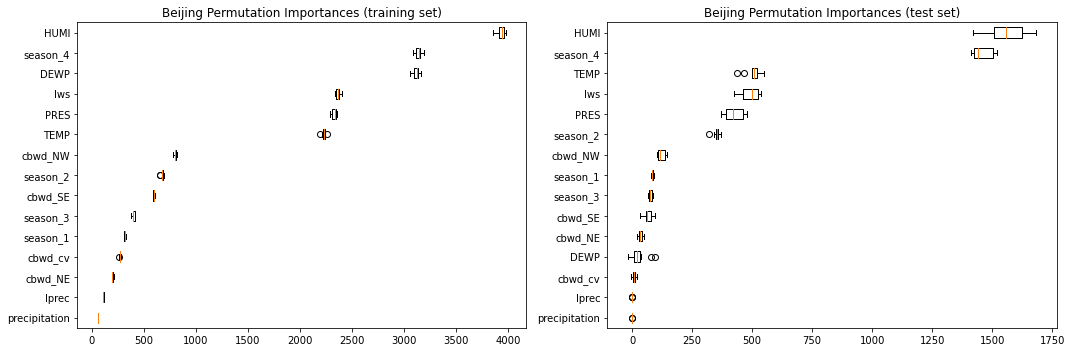

In [77]:
fi_beijing_tr = permutation_importance(beijing_rf_ft, beijing_m_tr.drop('PM_US Post', axis = 1),
                       beijing_m_tr['PM_US Post'], n_repeats=10,n_jobs=-1,scoring = 'neg_mean_squared_error', random_state = 19)
features_beijing_tr = fi_beijing_tr.importances_mean.argsort()

fi_beijing_test = permutation_importance(beijing_rf_ft, beijing_m_test.drop('PM_US Post', axis = 1),
                       beijing_m_test['PM_US Post'], n_repeats=10,n_jobs=-1,scoring = 'neg_mean_squared_error', random_state = 19)
features_beijing_test = fi_beijing_test.importances_mean.argsort()

#plot results
fig, axs = plt.subplots(1, 2, figsize = (15,5))
axs[0].boxplot(fi_beijing_tr.importances[features_beijing_tr].T,
           vert=False, labels=beijing_m_tr.drop('PM_US Post', axis = 1).columns[features_beijing_tr])
axs[1].boxplot(fi_beijing_test.importances[features_beijing_test].T,
           vert=False, labels=beijing_m_test.drop('PM_US Post', axis = 1).columns[features_beijing_test])
axs[0].set_title("Beijing Permutation Importances (training set)")
axs[1].set_title("Beijing Permutation Importances (test set)")
fig.tight_layout()
plt.show()

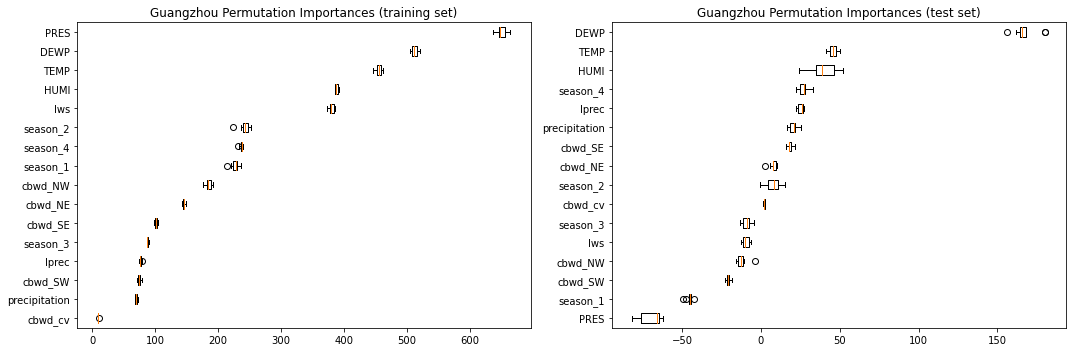

In [78]:
fi_guangzhou_tr = permutation_importance(guangzhou_rf_ft, guangzhou_m_tr.drop('PM_US Post', axis = 1),
                       guangzhou_m_tr['PM_US Post'], n_repeats=10,n_jobs=-1,scoring = 'neg_mean_squared_error', random_state = 19)
features_guangzhou_tr = fi_guangzhou_tr.importances_mean.argsort()

fi_guangzhou_test = permutation_importance(guangzhou_rf_ft, guangzhou_m_test.drop('PM_US Post', axis = 1),
                       guangzhou_m_test['PM_US Post'], n_repeats=10,n_jobs=-1,scoring = 'neg_mean_squared_error', random_state = 19)
features_guangzhou_test = fi_guangzhou_test.importances_mean.argsort()

#plot results
fig, axs = plt.subplots(1, 2, figsize = (15,5))
axs[0].boxplot(fi_guangzhou_tr.importances[features_guangzhou_tr].T,
           vert=False, labels=guangzhou_m_tr.drop('PM_US Post', axis = 1).columns[features_guangzhou_tr])
axs[1].boxplot(fi_guangzhou_test.importances[features_guangzhou_test].T,
           vert=False, labels=guangzhou_m_test.drop('PM_US Post', axis = 1).columns[features_guangzhou_test])
axs[0].set_title("Guangzhou Permutation Importances (training set)")
axs[1].set_title("Guangzhou Permutation Importances (test set)")
fig.tight_layout()
plt.show()

For Beijing, the two most important features agree. A radom shuffle of the Humidity and 4th Season worsens the $MSE$ by 4000 and 3500, respectively. Places four and five of the most important features also agree with cumulative wind speed and air pressure. Here the Random Forest model generalizes so well that a slight improvement over the benchmark model is apparent. This is in direct contrast to Guangzhou, where the most important features change their importance from the training set to the test set. The predictions on the test data are significantly worse than for the benchmark model. This is also underlined by the negative $R^2$ and it would be better to predict the particulate matter concentration always with the mean value. 

## 4.2 Gradient Boosting

Random forests uses multiple copies of  the training data in order to fit a decision tree. In a second step the separate and independent trees are combined to estimate the predictions (Hastie, p. 587-590). The main difference of Gradient boosting to Random Forests is, that the tree components $t_m = \{ T(x_1; \Theta_m),..., T(x_N; \Theta_m)\}^T$ are not independent (description and algorithm follow Hastie, p. 559-561). With $\Theta$ being the tree parameters. They are considered as predictions of a decision tree with $J_m$ terminal nodes, where the negative gradient is the unconstrained maximum descent direction. The tree predictions $T(xi;\Theta_m)$ are thus analogous to the components of the negative gradient. Unfortunately, the gradient exists only for the training data and does not necessarily represent new data. To address this problem gradient boosting induces a tree $T(x, \Theta_m)$ at the $m$th iteration whose predictions $t_m$ reflect the data as accurately as possible.

### 4.2.1 Extreme Gradient Boosting

For the following implementation the xgb library is used including the wrapper of sklearn. XGBoost stands for “Extreme Gradient Boosting”. The term “Gradient Boosting” was introduced in the paper "Greedy Function Approximation: A Gradient Boosting Machine" (Friedman 2001).
The goal of the xgb library is to provide a scalable, portable and accurate library for the Gradient Boosting Tree Algorithm (https://xgboost.readthedocs.io/en/latest/tutorials/model.html, last acess: August 30th 2021).

In [79]:
#import xgb library and with sklearn wrapper
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

### 4.2.2  Hyperparameter Tuning Extreme Gradient Boosting

The first hyperparameter of gradient boosting is the number of trees build. In order to fit complex datasets a large number of trees may be needed. Unlike Random Forests Gradient Boosting runs the risk of overfitting. Therefore the optimal number of trees has to be found with cross-validation. Before the other hyperparameters are tuned the number of trees for each city is determined. The xgb library provides a method for cross validation. The presented approach follows the proposed general method of https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/(last acess: September 30th 2021). 
1. Find the optimum number of trees for a high learning rate using the xgb function “cv” which performs cross-validation at each boosting iteration. The number of folds for cross-validation is 5 and the training stops if the performance metric does not improve for 10 rounds with a maximum of 1000 rounds in total.
2. Tune tree-specific parameters (max_depth, min_child_weight, gamma, subsample, colsample_bytree) for the learning rate and number of trees used in the first step. 
3. Tune regularization parameters (lambda, alpha) to help reduce model complexity and improve performance.
4. Lower learning rate to find the optimal parameters. 

To begin with, xgb´s default values are used:
- learning rate: 0.3
- max depth: 6
- min child weight: 1
- subsample: 1
- colsample by tree: 1
- gamma: 0

The detailed meaning of the respective parameter is explained later (parameter description follows xgb documentation https://xgboost.readthedocs.io/en/latest/parameter.html, last acess: September 30th 2021).

Since it is a regression problem, the default squared-error objective function is used.

### Step 1: Number of trees

In [212]:
#method to find number of trees
def xgb_ntrees(algo, data_train, folds_cv = 5, early_stopping = 10):
    
    #parameters from xgb algorithm
    xgb_params = algo.get_xgb_params()
    
    #Training data as DMatrix for xgb-Algorithm
    train = xgb.DMatrix(data_train.drop('PM_US Post', axis = 1), label=data_train['PM_US Post'])
    cvresult = xgb.cv(xgb_params, train, num_boost_round=algo.get_params()['n_estimators'], nfold=folds_cv,
             metrics='rmse', early_stopping_rounds=early_stopping)
    
    #set the so found number of trees as parameters
    algo.set_params(n_estimators=cvresult.shape[0])
    
    #Fit to training data
    algo.fit(data_train.drop('PM_US Post', axis = 1), data_train['PM_US Post'])
    
    #return fitted model and number of estimators
    return algo, cvresult.shape[0]  

In [213]:
#Parameters for Gradient Boosting
#The default parameters of xgb are used
xgb_beijing = XGBRegressor(learning_rate=0.3,n_estimators=1000,max_depth=6,min_child_weight=1,gamma=0,objective= 'reg:squarederror',seed=29)
xgb_chengdu = XGBRegressor(learning_rate=0.3,n_estimators=1000,max_depth=6,min_child_weight=1,gamma=0,objective= 'reg:squarederror',seed=29)
xgb_guangzhou = XGBRegressor(learning_rate=0.3,n_estimators=1000,max_depth=6,min_child_weight=1,gamma=0,objective= 'reg:squarederror',seed=29)
xgb_shanghai = XGBRegressor(learning_rate=0.3,n_estimators=1000,max_depth=6,min_child_weight=1,gamma=0,objective= 'reg:squarederror',seed=29)
xgb_shenyang = XGBRegressor(learning_rate=0.3,n_estimators=1000,max_depth=6,min_child_weight=1,gamma=0,objective= 'reg:squarederror',seed=29)

In [214]:
#determine number of estimators for every city
xgb_beijing,ntrees_beijing = xgb_ntrees(xgb_beijing, beijing_m_tr)
xgb_chengdu,ntrees_chengdu = xgb_ntrees(xgb_chengdu, chengdu_m_tr)
xgb_guangzhou,ntrees_guangzhou = xgb_ntrees(xgb_guangzhou, guangzhou_m_tr)
xgb_shanghai,ntrees_shanghai = xgb_ntrees(xgb_shanghai, shanghai_m_tr)
xgb_shenyang,ntrees_shenyang = xgb_ntrees(xgb_shenyang, shenyang_m_tr)

In [215]:
print('Number of estimators beijing: ' + str(ntrees_beijing))
print('Number of estimators chengdu: ' + str(ntrees_chengdu))
print('Number of estimators guangzhou: ' + str(ntrees_guangzhou))
print('Number of estimators shanghai: ' + str(ntrees_shanghai))
print('Number of estimators shenyang: ' + str(ntrees_shenyang))

Number of estimators beijing: 120
Number of estimators chengdu: 131
Number of estimators guangzhou: 65
Number of estimators shanghai: 212
Number of estimators shenyang: 130


Guangzhou requires the least number of estimators with only 65. Beijing, Chengdu and Shenyang need twice as many and Shanghai the highest number of estimators with 212. Prior to the fine tuning of the parameters the performance of the algorithm is evaluated. 

In [216]:
#save number of estimators
ntrees_beijing = 120
ntrees_chengdu = 131
ntrees_guangzhou = 65
ntrees_shanghai = 212
nrees_shenyang = 130

In [218]:
#check performance with test_set
for city in [[beijing_m_tr,beijing_m_test,'beijing', xgb_beijing],
             [chengdu_m_tr,chengdu_m_test,'chengdu', xgb_chengdu],
             [guangzhou_m_tr,guangzhou_m_test,'guangzhou', xgb_guangzhou],
             [shanghai_m_tr,shanghai_m_test,'shanghai', xgb_shanghai],
             [shenyang_m_tr,shenyang_m_test,'shenyang', xgb_shenyang]]:
    
    print_scores(city[3], data_train = city[0], data_valid = city[1],
                 y_col = 'PM_US Post', val_or_test = 'Test',city_name = city[2])

beijing : MSE =  7036.61 , R2 Train =  0.63 , R2 Test =  0.07 Change to base mse 28.73%.
chengdu : MSE =  2650.78 , R2 Train =  0.67 , R2 Test =  -0.62 Change to base mse 43.58%.
guangzhou : MSE =  1707.24 , R2 Train =  0.51 , R2 Test =  -2.35 Change to base mse 117.32%.
shanghai : MSE =  1557.66 , R2 Train =  0.78 , R2 Test =  -0.41 Change to base mse 72.39%.
shenyang : MSE =  3656.48 , R2 Train =  0.8 , R2 Test =  -0.14 Change to base mse 49.05%.


None of the cities is able to beat the benchmark model. The first results of gradient boosting worsen the mse of up to 117% compared to the benchmark model. 

### Step 2: Tune max_depth and min_child_weight

For the next step max_depth and min_child_weight are finetuned since they have the strongest impact on the model outcome (https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/, last acess: September 30th 2021). max_depth is the maximum depth of a tree. A deeper tree makes the model more complex and more likely to overfit. min_child_weight is the minimum sum of instance weight needed in a child. If the tree partitioning step results in a leaf node whose sum of instance weights is less than min_child_weight, then the build process will abandon further partitioning.

To begin with, wider ranges around the default values are used and reduced in a further step. Again sklearns grid search is used and the predefined splits for training and validation set.

In [239]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

def grid_xgb(cities):
    hyper_params = []
    for city in cities:
        print(city[2])
        
        #Define Train and Validation Set as scikit PredefinedSplit
        city[0]['test_fold'] = -1
        city[1]['test_fold'] = 0
        test_fold = pd.concat([city[0]['test_fold'], city[1]['test_fold']], axis = 0)
        ps = PredefinedSplit(test_fold)

        rf = XGBRegressor(learning_rate =0.3, n_estimators=city[4], max_depth=6, min_child_weight=1, gamma=0, 
                          objective= 'reg:squarederror', seed=19)

        grid_search = GridSearchCV(estimator = rf, param_grid = city[3], cv = ps, n_jobs = -1, verbose = 2,
                                   scoring='neg_mean_squared_error')

        city[0].drop('test_fold', axis = 1, inplace = True)
        city[1].drop('test_fold', axis = 1, inplace = True)

        city_train = pd.concat([city[0], city[1]], axis = 0)
        grid_search.fit(city_train.drop('PM_US Post', axis =1), city_train['PM_US Post'])

        #add model and best parameter combination to hyper_params
        hyper_params.append([city[2], grid_search])
        
    return hyper_params

In [240]:
#Create Grid
grid_beijing = {'max_depth':range(1,10,2), 'min_child_weight':range(1,6,2)}
grid_chengdu = {'max_depth':range(1,10,2), 'min_child_weight':range(1,6,2)}
grid_guangzhou = {'max_depth':range(1,10,2), 'min_child_weight':range(1,6,2)}
grid_shanghai = {'max_depth':range(1,10,2), 'min_child_weight':range(1,6,2)}
grid_shenyang = {'max_depth':range(1,10,2), 'min_child_weight':range(1,6,2)}

cities = [[beijing_m_tr,beijing_m_val, 'beijing', grid_beijing, ntrees_beijing],
             [chengdu_m_tr,chengdu_m_val, 'chengdu', grid_chengdu, ntrees_chengdu],
             [guangzhou_m_tr,guangzhou_m_val, 'guangzhou', grid_guangzhou, ntrees_guangzhou],
             [shanghai_m_tr,shanghai_m_val,'shanghai', grid_shanghai, ntrees_shanghai],
             [shenyang_m_tr,shenyang_m_val, 'shenyang', grid_shenyang, ntrees_shenyang]]

#tuned models after step 2
xgb_step2_t = grid_xgb(cities)

beijing
Fitting 1 folds for each of 15 candidates, totalling 15 fits
chengdu
Fitting 1 folds for each of 15 candidates, totalling 15 fits
guangzhou
Fitting 1 folds for each of 15 candidates, totalling 15 fits
shanghai
Fitting 1 folds for each of 15 candidates, totalling 15 fits
shenyang
Fitting 1 folds for each of 15 candidates, totalling 15 fits


In [241]:
for city in xgb_step2_t:
    print(city[0], ':' , city[1].best_params_)
    
print()

#check performance with test_set
for city in [[beijing_m_tr,beijing_m_test,'beijing', xgb_step2_t[0][1]],
             [chengdu_m_tr,chengdu_m_test,'chengdu', xgb_step2_t[1][1]],
             [guangzhou_m_tr,guangzhou_m_test,'guangzhou', xgb_step2_t[2][1]],
             [shanghai_m_tr,shanghai_m_test,'shanghai', xgb_step2_t[3][1]],
             [shenyang_m_tr,shenyang_m_test,'shenyang', xgb_step2_t[4][1]]]:
    
    print_scores(city[3], data_train = city[0], data_valid = city[1],
                 y_col = 'PM_US Post', val_or_test = 'Test',city_name = city[2])

beijing : {'max_depth': 3, 'min_child_weight': 5}
chengdu : {'max_depth': 1, 'min_child_weight': 1}
guangzhou : {'max_depth': 3, 'min_child_weight': 3}
shanghai : {'max_depth': 1, 'min_child_weight': 1}
shenyang : {'max_depth': 3, 'min_child_weight': 3}

beijing : MSE =  5690.26 , R2 Train =  0.48 , R2 Test =  0.25 Change to base mse 4.10%.
chengdu : MSE =  1753.4 , R2 Train =  0.34 , R2 Test =  -0.07 Change to base mse -5.02%.
guangzhou : MSE =  1118.13 , R2 Train =  0.29 , R2 Test =  -1.19 Change to base mse 42.33%.
shanghai : MSE =  953.68 , R2 Train =  0.3 , R2 Test =  0.14 Change to base mse 5.55%.
shenyang : MSE =  3017.14 , R2 Train =  0.52 , R2 Test =  0.06 Change to base mse 22.99%.


After the grid search with wider steps, the next search aims to improve the model by peforming another iteration with smaller steps.

In [242]:
#Create Grid
grid_beijing = {'max_depth':[2,3,4], 'min_child_weight':[4,5,6]}
grid_chengdu = {'max_depth':[1,2], 'min_child_weight':[1,2]}
grid_guangzhou = {'max_depth':[2,3,4], 'min_child_weight':[2,3,4]}
grid_shanghai = {'max_depth':[1,2], 'min_child_weight':[1,2]}
grid_shenyang = {'max_depth':[2,3,4], 'min_child_weight':[2,3,4]}

cities = [[beijing_m_tr,beijing_m_val, 'beijing', grid_beijing, ntrees_beijing],
             [chengdu_m_tr,chengdu_m_val, 'chengdu', grid_chengdu, ntrees_chengdu],
             [guangzhou_m_tr,guangzhou_m_val, 'guangzhou', grid_guangzhou, ntrees_guangzhou],
             [shanghai_m_tr,shanghai_m_val,'shanghai', grid_shanghai, ntrees_shanghai],
             [shenyang_m_tr,shenyang_m_val, 'shenyang', grid_shenyang, ntrees_shenyang]]

xgb_step2_ft = grid_xgb(cities)

beijing
Fitting 1 folds for each of 9 candidates, totalling 9 fits
chengdu
Fitting 1 folds for each of 4 candidates, totalling 4 fits
guangzhou
Fitting 1 folds for each of 9 candidates, totalling 9 fits
shanghai
Fitting 1 folds for each of 4 candidates, totalling 4 fits
shenyang
Fitting 1 folds for each of 9 candidates, totalling 9 fits


In [243]:
for city in xgb_step2_ft:
    print(city[0], ':' , city[1].best_params_)
    
print()

#check performance with test_set
for city in [[beijing_m_tr,beijing_m_test,'beijing', xgb_step2_ft[0][1]],
             [chengdu_m_tr,chengdu_m_test,'chengdu', xgb_step2_ft[1][1]],
             [guangzhou_m_tr,guangzhou_m_test,'guangzhou', xgb_step2_ft[2][1]],
             [shanghai_m_tr,shanghai_m_test,'shanghai', xgb_step2_ft[3][1]],
             [shenyang_m_tr,shenyang_m_test,'shenyang', xgb_step2_ft[4][1]]]:
    
    print_scores(city[3], data_train = city[0], data_valid = city[1],
                 y_col = 'PM_US Post', val_or_test = 'Test',city_name = city[2])

beijing : {'max_depth': 3, 'min_child_weight': 5}
chengdu : {'max_depth': 1, 'min_child_weight': 1}
guangzhou : {'max_depth': 2, 'min_child_weight': 2}
shanghai : {'max_depth': 2, 'min_child_weight': 2}
shenyang : {'max_depth': 2, 'min_child_weight': 4}

beijing : MSE =  5690.26 , R2 Train =  0.48 , R2 Test =  0.25 Change to base mse 4.10%.
chengdu : MSE =  1753.4 , R2 Train =  0.34 , R2 Test =  -0.07 Change to base mse -5.02%.
guangzhou : MSE =  958.54 , R2 Train =  0.24 , R2 Test =  -0.88 Change to base mse 22.02%.
shanghai : MSE =  929.15 , R2 Train =  0.37 , R2 Test =  0.16 Change to base mse 2.83%.
shenyang : MSE =  2912.55 , R2 Train =  0.44 , R2 Test =  0.09 Change to base mse 18.73%.


Beijing and Chengdu do not change their parameters. Guangzhou, Shanghai and Shenyang can improve their $MSE$. Only Chengdu can beat the bench mark model so far by 5%.

### Step 3: Tune Gamma

The third step focuses on tuning gamma. Gamma is the minimum loss reduction required to make a further partition on a leaf node of the tree and a larger gamma leads to a more conservative algorithm. Gamma ranges from 0 to ∞. With a default value of 0, the effects of small gamma values are analyzed. 

In [244]:
#Create Grid with values from step before and variants of beta
grid_beijing = {'max_depth':[3], 'min_child_weight':[5], 'gamma': [0,0.1,0.2,0.3,0.4]}
grid_chengdu = {'max_depth':[1], 'min_child_weight':[1],'gamma': [0,0.1,0.2,0.3,0.4]}
grid_guangzhou = {'max_depth':[2], 'min_child_weight':[2],'gamma': [0,0.1,0.2,0.3,0.4]}
grid_shanghai = {'max_depth':[2], 'min_child_weight':[2],'gamma': [0,0.1,0.2,0.3,0.4]}
grid_shenyang = {'max_depth':[2], 'min_child_weight':[4],'gamma': [0,0.1,0.2,0.3,0.4]}

cities = [[beijing_m_tr,beijing_m_val, 'beijing', grid_beijing, ntrees_beijing],
             [chengdu_m_tr,chengdu_m_val, 'chengdu', grid_chengdu, ntrees_chengdu],
             [guangzhou_m_tr,guangzhou_m_val, 'guangzhou', grid_guangzhou, ntrees_guangzhou],
             [shanghai_m_tr,shanghai_m_val,'shanghai', grid_shanghai, ntrees_shanghai],
             [shenyang_m_tr,shenyang_m_val, 'shenyang', grid_shenyang, ntrees_shenyang]]

xgb_step3_ft = grid_xgb(cities)

beijing
Fitting 1 folds for each of 5 candidates, totalling 5 fits
chengdu
Fitting 1 folds for each of 5 candidates, totalling 5 fits
guangzhou
Fitting 1 folds for each of 5 candidates, totalling 5 fits
shanghai
Fitting 1 folds for each of 5 candidates, totalling 5 fits
shenyang
Fitting 1 folds for each of 5 candidates, totalling 5 fits


In [245]:
for city in xgb_step3_ft:
    print(city[0], ':' , city[1].best_params_)
    
print()

#check performance with test_set
for city in [[beijing_m_tr,beijing_m_test,'beijing', xgb_step3_ft[0][1]],
             [chengdu_m_tr,chengdu_m_test,'chengdu', xgb_step3_ft[1][1]],
             [guangzhou_m_tr,guangzhou_m_test,'guangzhou', xgb_step3_ft[2][1]],
             [shanghai_m_tr,shanghai_m_test,'shanghai', xgb_step3_ft[3][1]],
             [shenyang_m_tr,shenyang_m_test,'shenyang', xgb_step3_ft[4][1]]]:
    
    print_scores(city[3], data_train = city[0], data_valid = city[1],
                 y_col = 'PM_US Post', val_or_test = 'Test',city_name = city[2])

beijing : {'gamma': 0, 'max_depth': 3, 'min_child_weight': 5}
chengdu : {'gamma': 0, 'max_depth': 1, 'min_child_weight': 1}
guangzhou : {'gamma': 0, 'max_depth': 2, 'min_child_weight': 2}
shanghai : {'gamma': 0, 'max_depth': 2, 'min_child_weight': 2}
shenyang : {'gamma': 0, 'max_depth': 2, 'min_child_weight': 4}

beijing : MSE =  5690.26 , R2 Train =  0.48 , R2 Test =  0.25 Change to base mse 4.10%.
chengdu : MSE =  1753.4 , R2 Train =  0.34 , R2 Test =  -0.07 Change to base mse -5.02%.
guangzhou : MSE =  958.54 , R2 Train =  0.24 , R2 Test =  -0.88 Change to base mse 22.02%.
shanghai : MSE =  929.15 , R2 Train =  0.37 , R2 Test =  0.16 Change to base mse 2.83%.
shenyang : MSE =  2912.55 , R2 Train =  0.44 , R2 Test =  0.09 Change to base mse 18.73%.


0 is the best gamma value for all cities.

### Step 4: Tune subsample and colsample_bytree

Subsample is the ratio of the training instances. At a value of 0.5 XGBoost randomly samples half of the training data before growing the trees to prevent overfitting (https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters, last acess: September 30th 2021). Colsample_bytree denotes the subsample ratio of columns when constructing a tree and occurs once for every tree constructed. The tuning is done with values of 0.6,0.7,0.8,0.9 and 1.0 for both. 

In [249]:
#Create Grid with values from step before and variants of beta
grid_beijing = {'max_depth':[3], 'min_child_weight':[5],  'subsample':[i/10.0 for i in range(6,11)],
 'colsample_bytree':[i/10.0 for i in range(6,11)]}
grid_chengdu = {'max_depth':[1], 'min_child_weight':[1],'subsample':[i/10.0 for i in range(6,11)],
 'colsample_bytree':[i/10.0 for i in range(6,11)]}
grid_guangzhou = {'max_depth':[2], 'min_child_weight':[2],'subsample':[i/10.0 for i in range(6,11)],
 'colsample_bytree':[i/10.0 for i in range(6,11)]}
grid_shanghai = {'max_depth':[2], 'min_child_weight':[2],'subsample':[i/10.0 for i in range(6,11)],
 'colsample_bytree':[i/10.0 for i in range(6,11)]}
grid_shenyang = {'max_depth':[2], 'min_child_weight':[4],'subsample':[i/10.0 for i in range(6,11)],
 'colsample_bytree':[i/10.0 for i in range(6,11)]}

cities = [[beijing_m_tr,beijing_m_val, 'beijing', grid_beijing, ntrees_beijing],
             [chengdu_m_tr,chengdu_m_val, 'chengdu', grid_chengdu, ntrees_chengdu],
             [guangzhou_m_tr,guangzhou_m_val, 'guangzhou', grid_guangzhou, ntrees_guangzhou],
             [shanghai_m_tr,shanghai_m_val,'shanghai', grid_shanghai, ntrees_shanghai],
             [shenyang_m_tr,shenyang_m_val, 'shenyang', grid_shenyang, ntrees_shenyang]]

xgb_step4_ft = grid_xgb(cities)

beijing
Fitting 1 folds for each of 25 candidates, totalling 25 fits
chengdu
Fitting 1 folds for each of 25 candidates, totalling 25 fits
guangzhou
Fitting 1 folds for each of 25 candidates, totalling 25 fits
shanghai
Fitting 1 folds for each of 25 candidates, totalling 25 fits
shenyang
Fitting 1 folds for each of 25 candidates, totalling 25 fits


In [250]:
for city in xgb_step4_ft:
    print(city[0], ':' , city[1].best_params_)
    
print()

#check performance with test_set
for city in [[beijing_m_tr,beijing_m_test,'beijing', xgb_step4_ft[0][1]],
             [chengdu_m_tr,chengdu_m_test,'chengdu', xgb_step4_ft[1][1]],
             [guangzhou_m_tr,guangzhou_m_test,'guangzhou', xgb_step4_ft[2][1]],
             [shanghai_m_tr,shanghai_m_test,'shanghai', xgb_step4_ft[3][1]],
             [shenyang_m_tr,shenyang_m_test,'shenyang', xgb_step4_ft[4][1]]]:
    
    print_scores(city[3], data_train = city[0], data_valid = city[1],
                 y_col = 'PM_US Post', val_or_test = 'Test',city_name = city[2])

beijing : {'colsample_bytree': 1.0, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 1.0}
chengdu : {'colsample_bytree': 0.6, 'max_depth': 1, 'min_child_weight': 1, 'subsample': 0.6}
guangzhou : {'colsample_bytree': 0.9, 'max_depth': 2, 'min_child_weight': 2, 'subsample': 1.0}
shanghai : {'colsample_bytree': 0.6, 'max_depth': 2, 'min_child_weight': 2, 'subsample': 0.8}
shenyang : {'colsample_bytree': 0.8, 'max_depth': 2, 'min_child_weight': 4, 'subsample': 0.8}

beijing : MSE =  5690.26 , R2 Train =  0.48 , R2 Test =  0.25 Change to base mse 4.10%.
chengdu : MSE =  1812.53 , R2 Train =  0.34 , R2 Test =  -0.1 Change to base mse -1.82%.
guangzhou : MSE =  938.27 , R2 Train =  0.24 , R2 Test =  -0.84 Change to base mse 19.44%.
shanghai : MSE =  944.9 , R2 Train =  0.37 , R2 Test =  0.14 Change to base mse 4.58%.
shenyang : MSE =  3304.15 , R2 Train =  0.44 , R2 Test =  -0.03 Change to base mse 34.69%.


Only Guangzhou can slightly improve the previous $MSE$ by setting colsample_bytree to 0.9 and subsample to 1.0. For Beijing, Chengdu, Guangzhou and Shenyang the default value of 1 yields better results.

### Step 5: Tuning Regularization

Even though gamma already impacts the complexity, the next step uses different L2 regularization terms on weights. With a default value of 0 an increase will make the model more conservative (https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters, last acess: September 30th 2021). The previous tuning steps already give a hint that Gradient Boosting seems not to be the best approach for the underlying dataset. One explanation that comes to mind is a strong overfit on the training data despite the actions in previous steps. Nevertheless, the tuning regularization is done before reducing the learning rate in the last step. To see whether regularization has a positive impact on the result, a broad spectrum is tried out: reg_alpha = (1e-05, 0.01, 0.1, 100).

In [251]:
#Create Grid with values from step before and variants of beta
grid_beijing = {'max_depth':[3], 'min_child_weight':[5], 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100] }
grid_chengdu = {'max_depth':[1], 'min_child_weight':[1],'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
grid_guangzhou = {'max_depth':[2], 'min_child_weight':[2],'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100], 'subsample':[1.0],
 'colsample_bytree':[0.9]}
grid_shanghai = {'max_depth':[2], 'min_child_weight':[2],'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
grid_shenyang = {'max_depth':[2], 'min_child_weight':[4],'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}

cities = [[beijing_m_tr,beijing_m_val, 'beijing', grid_beijing, ntrees_beijing],
             [chengdu_m_tr,chengdu_m_val, 'chengdu', grid_chengdu, ntrees_chengdu],
             [guangzhou_m_tr,guangzhou_m_val, 'guangzhou', grid_guangzhou, ntrees_guangzhou],
             [shanghai_m_tr,shanghai_m_val,'shanghai', grid_shanghai, ntrees_shanghai],
             [shenyang_m_tr,shenyang_m_val, 'shenyang', grid_shenyang, ntrees_shenyang]]

xgb_step5_ft = grid_xgb(cities)

beijing
Fitting 1 folds for each of 5 candidates, totalling 5 fits
chengdu
Fitting 1 folds for each of 5 candidates, totalling 5 fits
guangzhou
Fitting 1 folds for each of 5 candidates, totalling 5 fits
shanghai
Fitting 1 folds for each of 5 candidates, totalling 5 fits
shenyang
Fitting 1 folds for each of 5 candidates, totalling 5 fits


In [252]:
for city in xgb_step5_ft:
    print(city[0], ':' , city[1].best_params_)
    
print()

#check performance with test_set
for city in [[beijing_m_tr,beijing_m_test,'beijing', xgb_step5_ft[0][1]],
             [chengdu_m_tr,chengdu_m_test,'chengdu', xgb_step5_ft[1][1]],
             [guangzhou_m_tr,guangzhou_m_test,'guangzhou', xgb_step5_ft[2][1]],
             [shanghai_m_tr,shanghai_m_test,'shanghai', xgb_step5_ft[3][1]],
             [shenyang_m_tr,shenyang_m_test,'shenyang', xgb_step5_ft[4][1]]]:
    
    print_scores(city[3], data_train = city[0], data_valid = city[1],
                 y_col = 'PM_US Post', val_or_test = 'Test',city_name = city[2])

beijing : {'max_depth': 3, 'min_child_weight': 5, 'reg_alpha': 1e-05}
chengdu : {'max_depth': 1, 'min_child_weight': 1, 'reg_alpha': 100}
guangzhou : {'colsample_bytree': 0.9, 'max_depth': 2, 'min_child_weight': 2, 'reg_alpha': 0.1, 'subsample': 1.0}
shanghai : {'max_depth': 2, 'min_child_weight': 2, 'reg_alpha': 0.1}
shenyang : {'max_depth': 2, 'min_child_weight': 4, 'reg_alpha': 1}

beijing : MSE =  5690.26 , R2 Train =  0.48 , R2 Test =  0.25 Change to base mse 4.10%.
chengdu : MSE =  1754.24 , R2 Train =  0.34 , R2 Test =  -0.07 Change to base mse -4.98%.
guangzhou : MSE =  938.11 , R2 Train =  0.24 , R2 Test =  -0.84 Change to base mse 19.42%.
shanghai : MSE =  929.15 , R2 Train =  0.37 , R2 Test =  0.16 Change to base mse 2.83%.
shenyang : MSE =  2970.78 , R2 Train =  0.44 , R2 Test =  0.08 Change to base mse 21.10%.


In [257]:
xgb_step5_ft[0][1]

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.3, max_delta_step=None,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_con...=None,
                                    n_estimators=120, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, seed=19,
                                   

For Beijing, Guangzhou and Shanghai the value of the regularization term is small and no improvement (or very little) of the $MSE$ occurs. Therefore the default value of 0 will be kept. Chengdu and Shenyang show higher optimal values of the regularization term. Because there is no gain in terms of $MSE$ the default value is kept too.

### Step 6: Adjust Learning Rate

Before the learning rate is adjusted, the number of trees is checked to find out, whether the parameter tuning raises the need for an adjustment.

In [255]:
#Parameters for Gradient Boosting
#The found parameters are used
xgb_beijing_6 = XGBRegressor(learning_rate=0.3,n_estimators=1000,max_depth=3,min_child_weight=5,gamma=0,objective= 'reg:squarederror',seed=29)
xgb_chengdu_6 = XGBRegressor(learning_rate=0.3,n_estimators=1000,max_depth=1,min_child_weight=1,gamma=0,objective= 'reg:squarederror',seed=29)
xgb_guangzhou_6 = XGBRegressor(learning_rate=0.3,n_estimators=1000,max_depth=2,min_child_weight=2,gamma=0, objective= 'reg:squarederror',seed=29,
                               subsample=1.0, colsample_bytree=0.9)
xgb_shanghai_6 = XGBRegressor(learning_rate=0.3,n_estimators=1000,max_depth=2,min_child_weight=2,gamma=0, objective= 'reg:squarederror',seed=29)
xgb_shenyang_6 = XGBRegressor(learning_rate=0.3,n_estimators=1000,max_depth=2,min_child_weight=4,gamma=0,objective= 'reg:squarederror',seed=29)

In [256]:
#determine number of estimators for every city
xgb_beijing_6,ntrees_beijing_6 = xgb_ntrees(xgb_beijing_6, beijing_m_tr)
xgb_chengdu_6,ntrees_chengdu_6 = xgb_ntrees(xgb_chengdu_6, chengdu_m_tr)
xgb_guangzhou_6,ntrees_guangzhou_6 = xgb_ntrees(xgb_guangzhou_6, guangzhou_m_tr)
xgb_shanghai_6,ntrees_shanghai_6 = xgb_ntrees(xgb_shanghai_6, shanghai_m_tr)
xgb_shenyang_6,ntrees_shenyang_6 = xgb_ntrees(xgb_shenyang_6, shenyang_m_tr)

In [258]:
print('Number of estimators beijing: ' + str(ntrees_beijing_6))
print('Number of estimators chengdu: ' + str(ntrees_chengdu_6))
print('Number of estimators guangzhou: ' + str(ntrees_guangzhou_6))
print('Number of estimators shanghai: ' + str(ntrees_shanghai_6))
print('Number of estimators shenyang: ' + str(ntrees_shenyang_6))

Number of estimators beijing: 658
Number of estimators chengdu: 594
Number of estimators guangzhou: 467
Number of estimators shanghai: 455
Number of estimators shenyang: 504


The number of estimators increases for every city. The next step shows, if a smaller learning rate can further improve the results.

In [259]:
xgb_beijing_lr = XGBRegressor(learning_rate=0.3,n_estimators=658,max_depth=3,min_child_weight=5,gamma=0,objective= 'reg:squarederror',seed=29)
xgb_chengdu_lr = XGBRegressor(learning_rate=0.3,n_estimators=594,max_depth=1,min_child_weight=1,gamma=0,objective= 'reg:squarederror',seed=29)
xgb_guangzhou_lr = XGBRegressor(learning_rate=0.3,n_estimators=467,max_depth=2,min_child_weight=2,gamma=0,objective= 'reg:squarederror',subsample=1.0, colsample_bytree=0.9,seed=29)
xgb_shanghai_lr = XGBRegressor(learning_rate=0.3,n_estimators=455,max_depth=2,min_child_weight=2,gamma=0, objective= 'reg:squarederror',seed=29)
xgb_shenyang_lr = XGBRegressor(learning_rate=0.3,n_estimators=504,max_depth=2,min_child_weight=4,gamma=0,objective= 'reg:squarederror',seed=29)

#Create Grid with low learning rates
grid_beijing = {'learning_rate':[0.1, 0.01]}
grid_chengdu = {'learning_rate':[0.1, 0.01]}
grid_guangzhou = {'learning_rate':[0.1, 0.01]}
grid_shanghai = {'learning_rate':[0.1, 0.01]}
grid_shenyang = {'learning_rate':[0.1, 0.01]}

cities = [[beijing_m_tr,beijing_m_val, 'beijing', grid_beijing, ntrees_beijing_6],
             [chengdu_m_tr,chengdu_m_val, 'chengdu', grid_chengdu, ntrees_chengdu_6],
             [guangzhou_m_tr,guangzhou_m_val, 'guangzhou', grid_guangzhou, ntrees_guangzhou_6],
             [shanghai_m_tr,shanghai_m_val,'shanghai', grid_shanghai, ntrees_shanghai_6],
             [shenyang_m_tr,shenyang_m_val, 'shenyang', grid_shenyang, ntrees_shenyang_6]]

xgb_step6_lr = grid_xgb(cities)

beijing
Fitting 1 folds for each of 2 candidates, totalling 2 fits
chengdu
Fitting 1 folds for each of 2 candidates, totalling 2 fits
guangzhou
Fitting 1 folds for each of 2 candidates, totalling 2 fits
shanghai
Fitting 1 folds for each of 2 candidates, totalling 2 fits
shenyang
Fitting 1 folds for each of 2 candidates, totalling 2 fits


In [260]:
for city in xgb_step6_lr:
    print(city[0], ':' , city[1].best_params_)
    
print()

#check performance with test_set
for city in [[beijing_m_tr,beijing_m_test,'beijing', xgb_step6_lr[0][1]],
             [chengdu_m_tr,chengdu_m_test,'chengdu', xgb_step6_lr[1][1]],
             [guangzhou_m_tr,guangzhou_m_test,'guangzhou', xgb_step6_lr[2][1]],
             [shanghai_m_tr,shanghai_m_test,'shanghai', xgb_step6_lr[3][1]],
             [shenyang_m_tr,shenyang_m_test,'shenyang', xgb_step6_lr[4][1]]]:
    
    print_scores(city[3], data_train = city[0], data_valid = city[1],
                 y_col = 'PM_US Post', val_or_test = 'Test',city_name = city[2])

beijing : {'learning_rate': 0.01}
chengdu : {'learning_rate': 0.01}
guangzhou : {'learning_rate': 0.01}
shanghai : {'learning_rate': 0.01}
shenyang : {'learning_rate': 0.01}

beijing : MSE =  5295.86 , R2 Train =  0.51 , R2 Test =  0.3 Change to base mse -3.12%.
chengdu : MSE =  1875.75 , R2 Train =  0.49 , R2 Test =  -0.14 Change to base mse 1.60%.
guangzhou : MSE =  947.08 , R2 Train =  0.36 , R2 Test =  -0.86 Change to base mse 20.56%.
shanghai : MSE =  902.51 , R2 Train =  0.44 , R2 Test =  0.18 Change to base mse -0.11%.
shenyang : MSE =  2869.19 , R2 Train =  0.54 , R2 Test =  0.11 Change to base mse 16.96%.


In [261]:
xgb_beijing_lr = XGBRegressor(learning_rate=0.3,n_estimators=658,max_depth=3,min_child_weight=5,gamma=0,objective= 'reg:squarederror',seed=29)
xgb_chengdu_lr = XGBRegressor(learning_rate=0.3,n_estimators=594,max_depth=1,min_child_weight=1,gamma=0,objective= 'reg:squarederror',seed=29)
xgb_guangzhou_lr = XGBRegressor(learning_rate=0.3,n_estimators=467,max_depth=2,min_child_weight=2,gamma=0,objective= 'reg:squarederror',subsample=1.0, colsample_bytree=0.9,seed=29)
xgb_shanghai_lr = XGBRegressor(learning_rate=0.3,n_estimators=455,max_depth=2,min_child_weight=2,gamma=0, objective= 'reg:squarederror',seed=29)
xgb_shenyang_lr = XGBRegressor(learning_rate=0.3,n_estimators=504,max_depth=2,min_child_weight=4,gamma=0,objective= 'reg:squarederror',seed=29)


#Create Grid with low learning rates
grid_beijing = {'learning_rate':[0.015, 0.01, 0.05]}
grid_chengdu = {'learning_rate':[0.015, 0.01, 0.05]}
grid_guangzhou = {'learning_rate':[0.015, 0.01, 0.05]}
grid_shanghai = {'learning_rate':[0.015, 0.01, 0.05]}
grid_shenyang = {'learning_rate':[0.015, 0.01, 0.05]}

cities = [[beijing_m_tr,beijing_m_val, 'beijing', grid_beijing, ntrees_beijing_6],
             [chengdu_m_tr,chengdu_m_val, 'chengdu', grid_chengdu, ntrees_chengdu_6],
             [guangzhou_m_tr,guangzhou_m_val, 'guangzhou', grid_guangzhou, ntrees_guangzhou_6],
             [shanghai_m_tr,shanghai_m_val,'shanghai', grid_shanghai, ntrees_shanghai_6],
             [shenyang_m_tr,shenyang_m_val, 'shenyang', grid_shenyang, ntrees_shenyang_6]]

#learning rate fine tuning
xgb_step6_lrft = grid_xgb(cities)

beijing
Fitting 1 folds for each of 3 candidates, totalling 3 fits
chengdu
Fitting 1 folds for each of 3 candidates, totalling 3 fits
guangzhou
Fitting 1 folds for each of 3 candidates, totalling 3 fits
shanghai
Fitting 1 folds for each of 3 candidates, totalling 3 fits
shenyang
Fitting 1 folds for each of 3 candidates, totalling 3 fits


In [262]:
for city in xgb_step6_lrft:
    print(city[0], ':' , city[1].best_params_)
    
print()

#check performance with test_set
for city in [[beijing_m_tr,beijing_m_test,'beijing', xgb_step6_lrft[0][1]],
             [chengdu_m_tr,chengdu_m_test,'chengdu', xgb_step6_lrft[1][1]],
             [guangzhou_m_tr,guangzhou_m_test,'guangzhou', xgb_step6_lrft[2][1]],
             [shanghai_m_tr,shanghai_m_test,'shanghai', xgb_step6_lrft[3][1]],
             [shenyang_m_tr,shenyang_m_test,'shenyang', xgb_step6_lrft[4][1]]]:
    
    print_scores(city[3], data_train = city[0], data_valid = city[1],
                 y_col = 'PM_US Post', val_or_test = 'Test',city_name = city[2])

beijing : {'learning_rate': 0.015}
chengdu : {'learning_rate': 0.01}
guangzhou : {'learning_rate': 0.01}
shanghai : {'learning_rate': 0.01}
shenyang : {'learning_rate': 0.01}

beijing : MSE =  5356.89 , R2 Train =  0.53 , R2 Test =  0.29 Change to base mse -2.00%.
chengdu : MSE =  1875.75 , R2 Train =  0.49 , R2 Test =  -0.14 Change to base mse 1.60%.
guangzhou : MSE =  947.08 , R2 Train =  0.36 , R2 Test =  -0.86 Change to base mse 20.56%.
shanghai : MSE =  902.51 , R2 Train =  0.44 , R2 Test =  0.18 Change to base mse -0.11%.
shenyang : MSE =  2869.19 , R2 Train =  0.54 , R2 Test =  0.11 Change to base mse 16.96%.


In [279]:
# #save model
# import pickle
# from joblib import dump

# dump(xgb_step6_lrft[0][1], '/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/models/beijing_xgb_final.joblib')
# dump(xgb_step6_lrft[1][1], '/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/models/chengdu_xgb_final.joblib')
# dump(xgb_step6_lrft[2][1], '/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/models/guangzhou_xgb_final.joblib')
# dump(xgb_step6_lrft[3][1], '/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/models/shanghai_xgb_final.joblib')
# dump(xgb_step6_lrft[4][1], '/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/models/shenyang_xgb_final.joblib')

['/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/models/shenyang_xgb_final.joblib']

In General, Gradient Boosting performs better than Random Forests. With a small learning rate Beijing and Shanghai can beat the benchmark model. With a larger learning rate Chengdu can beat the benchmark model as well. Again, Guangzhou performs worse. In the next step, the feature importance is analyzed to give an insight why the results are achieved. As for Random Forests, Beijing as a well performing and Guangzhou as a worse performing model are used.

### 4.2.3 Feature Importance

In [80]:
from joblib import load

#import finetuned models
beijing_xgb_ft = load('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/models/beijing_xgb_final.joblib')
chengdu_xgb_ft = load('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/models/chengdu_xgb_final.joblib')
guangzhou_xgb_ft = load('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/models/guangzhou_xgb_final.joblib')
shanghai_xgb_ft = load('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/models/shanghai_xgb_final.joblib')
shenyang_xgb_ft = load('/Users/johannesthellmann/Desktop/SoSe2021/Introduction to Statistical Machine Learning/Report/Dataset/models/shenyang_xgb_final.joblib')

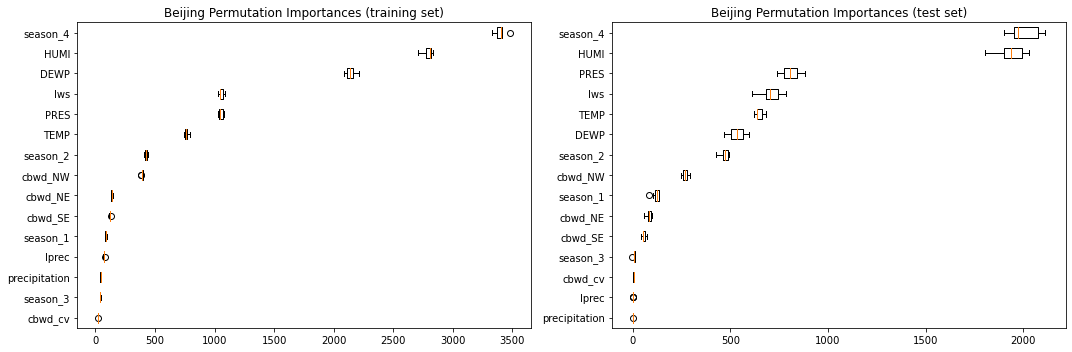

In [81]:
fi_beijing_tr_xgb = permutation_importance(beijing_xgb_ft, beijing_m_tr.drop('PM_US Post', axis = 1),
                       beijing_m_tr['PM_US Post'], n_repeats=10,n_jobs=-1, scoring = 'neg_mean_squared_error', random_state = 19)
features_beijing_tr_xgb = fi_beijing_tr_xgb.importances_mean.argsort()

fi_beijing_test_xgb = permutation_importance(beijing_xgb_ft, beijing_m_test.drop('PM_US Post', axis = 1),
                       beijing_m_test['PM_US Post'], n_repeats=10,n_jobs=-1, scoring = 'neg_mean_squared_error', random_state = 19)
features_beijing_test_xgb = fi_beijing_test_xgb.importances_mean.argsort()

#plot results
fig, axs = plt.subplots(1, 2, figsize = (15,5))
axs[0].boxplot(fi_beijing_tr_xgb.importances[features_beijing_tr_xgb].T,
           vert=False, labels=beijing_m_tr.drop('PM_US Post', axis = 1).columns[features_beijing_tr_xgb])
axs[1].boxplot(fi_beijing_test_xgb.importances[features_beijing_test_xgb].T,
           vert=False, labels=beijing_m_test.drop('PM_US Post', axis = 1).columns[features_beijing_test_xgb])
axs[0].set_title("Beijing Permutation Importances (training set)")
axs[1].set_title("Beijing Permutation Importances (test set)")
fig.tight_layout()
plt.show()

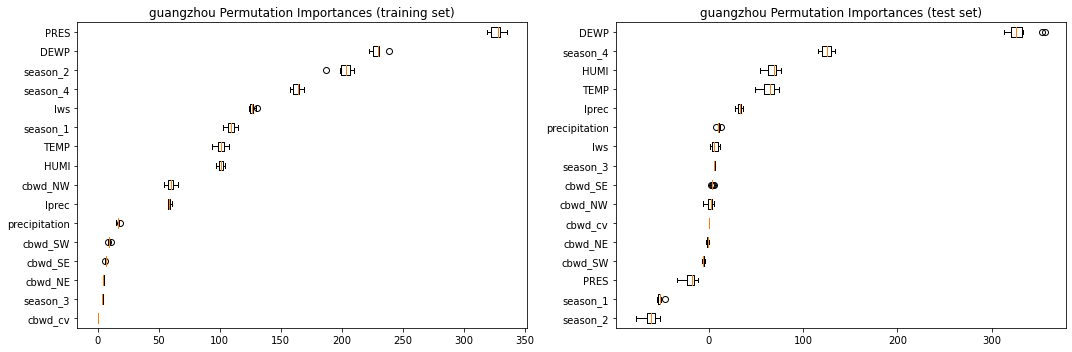

In [82]:
fi_guangzhou_tr_xgb = permutation_importance(guangzhou_xgb_ft, guangzhou_m_tr.drop('PM_US Post', axis = 1),
                       guangzhou_m_tr['PM_US Post'], n_repeats=10,n_jobs=-1, scoring = 'neg_mean_squared_error', random_state = 19)
features_guangzhou_tr_xgb = fi_guangzhou_tr_xgb.importances_mean.argsort()

fi_guangzhou_test_xgb = permutation_importance(guangzhou_xgb_ft, guangzhou_m_test.drop('PM_US Post', axis = 1),
                       guangzhou_m_test['PM_US Post'], n_repeats=10,n_jobs=-1, scoring = 'neg_mean_squared_error', random_state = 19)
features_guangzhou_test_xgb = fi_guangzhou_test_xgb.importances_mean.argsort()

#plot results
fig, axs = plt.subplots(1, 2, figsize = (15,5))
axs[0].boxplot(fi_guangzhou_tr_xgb.importances[features_guangzhou_tr_xgb].T,
           vert=False, labels=guangzhou_m_tr.drop('PM_US Post', axis = 1).columns[features_guangzhou_tr_xgb])
axs[1].boxplot(fi_guangzhou_test_xgb.importances[features_guangzhou_test_xgb].T,
           vert=False, labels=guangzhou_m_test.drop('PM_US Post', axis = 1).columns[features_guangzhou_test_xgb])
axs[0].set_title("guangzhou Permutation Importances (training set)")
axs[1].set_title("guangzhou Permutation Importances (test set)")
fig.tight_layout()
plt.show()

The feature importance plots for Beijing look very similar to the ones for Random Forests. Season 4, Humidity and cumulated windspeed are three of the four most important features both for the training and the test set. Leaving one of these features out worsens the $MSE$ significantly. An alike dependence cannot be observed for Guangzhou. In this point there is again a correspondence to Random Forests.

# 5. Conclusion

The goal of this report was to create a machine learning model to predict partial matter concentration values based on meteorological features. These predictions can then be used to implement day-dependent measures such as driving bans in major cities. This is to guarantee acceptable air quality in the short and medium term. Due to the poor performance of a simple linear regression model, Random Forests and Gradient Boosting were proposed. However, both models could only slightly outperform the Mean-Squared-Error and this only for certain cities. The Mean-Squared-Error in both the linear and the two machine learning models is of a magnitude that makes the application described above impossible.
Interesting at this point is that the largest dataset Beijing, performs well (compared to the other cities) in both models. This raises the question of whether the datasets of the other cities contain too little training data to generalize properly. This is also supported by the fact that in the feature importance analysis, the most important features for Beijing are found by the model, but not for Guangzhou, for example. 

The issue of air quality in major cities will remain significant in the coming years, ensuring the need for predictive models. In the dataset used, hourly data were used. At this point, it would be conceivable to aggregate the data over several hours to produce a more robust model. However, the question here is how to handle categorical data, such as wind direction. Or whether wind direction affects particular matter levels with a time lag, and only after a period of strong northwest wind does the concentration change.
Another parameter, which was not considered in the model, is the time of day. During periods of high traffic, e.g. during business hours, the particulate matter concentration could mainly depend on it.
In chapter 2, no exact general trend of particulate matter was found, but a certain seasonality was found. Here, LSTM Neural Networks, which take into account previous data, can be used.
Lastly, the idea that exact concentration levels were predicted in the previous report, but cities mostly impose driving bans based on thresholds, suggests itself. This turns the problem into a classification problem and puts the weather forecast data into categories of high or low particulate matter risk.

## Bibliography

Paper
- Friedman, Jerome H. "Greedy function approximation: a gradient boosting machine." Annals of statistics (2001): 1189-1232.
- Breiman, Leo. "Random forests." Machine learning 45.1 (2001): 5-32.
- Liang, Xuan, et al. "PM2. 5 data reliability, consistency, and air quality assessment in five Chinese cities." Journal of Geophysical Research: Atmospheres 121.17 (2016): 10-220.
- Zamani Joharestani, Mehdi, et al. "PM2. 5 prediction based on random forest, XGBoost, and deep learning using multisource remote sensing data." Atmosphere 10.7 (2019): 373.
- Brokamp, Cole, et al. "Exposure assessment models for elemental components of particulate matter in an urban environment: A comparison of regression and random forest approaches." Atmospheric Environment 151 (2017): 1-11.

Books
- Hastie, Trevor, Tibshirani, Robert and Friedman, Jerome. The Elements of Statistical Learning. New York, NY, USA: Springer New York Inc., 2001.
- Aurélien, Géron. Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow. O´reilly Media, Inc., 2019.

Notebooks
- NB7_Bonus Exercise, Introduction to Statistical Machine Learning, Acess: September 30th 2021

## Declaration

I hereby declare that I have prepared the present seminar paper. I have prepared this seminar paper independently. The thoughts taken directly or indirectly from external sources are marked as such.

Karlsruhe September 30th 2021, Johannes Thellmann